In [3]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 3
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df) 

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 3
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

3
179
(84, 2151)
(11, 2151)


[I 2025-05-18 23:16:58,210] A new study created in memory with name: no-name-cbc1b9d6-f225-47c9-9132-fd197d49b803
[I 2025-05-18 23:23:20,247] Trial 0 finished with value: 0.05361201837658882 and parameters: {'lr': 0.05316928905074732, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3473378648304098}. Best is trial 0 with value: 0.05361201837658882.


Cross Validation Accuracies:
[0.044201482087373734, 0.051353517919778824, 0.06556294113397598, 0.06222892180085182, 0.044713228940963745]
Mean Cross Validation Accuracy:
0.05361201837658882
Standard Deviation of Cross Validation Accuracy:
0.008830889540241655


[I 2025-05-18 23:28:10,434] Trial 1 finished with value: 4.185074186325073 and parameters: {'lr': 0.38036637024869446, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.41156959328687226}. Best is trial 0 with value: 0.05361201837658882.


Cross Validation Accuracies:
[5.521899700164795, 3.0379178524017334, 3.81735897064209, 5.981158256530762, 2.5670361518859863]
Mean Cross Validation Accuracy:
4.185074186325073
Standard Deviation of Cross Validation Accuracy:
1.347757371109221


[I 2025-05-18 23:34:02,604] Trial 2 finished with value: 0.39527963995933535 and parameters: {'lr': 0.016849674934318295, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14818927695421855}. Best is trial 0 with value: 0.05361201837658882.


Cross Validation Accuracies:
[0.39269450306892395, 0.43702271580696106, 0.36351442337036133, 0.38876742124557495, 0.39439913630485535]
Mean Cross Validation Accuracy:
0.39527963995933535
Standard Deviation of Cross Validation Accuracy:
0.023670152421007486


[I 2025-05-18 23:38:32,284] Trial 3 finished with value: 0.05461866185069084 and parameters: {'lr': 0.0021306883338450106, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26128576466038744}. Best is trial 0 with value: 0.05361201837658882.


Cross Validation Accuracies:
[0.047692131251096725, 0.03719276934862137, 0.055219098925590515, 0.06510178744792938, 0.06788752228021622]
Mean Cross Validation Accuracy:
0.05461866185069084
Standard Deviation of Cross Validation Accuracy:
0.01129564216596304


[I 2025-05-18 23:43:09,403] Trial 4 finished with value: 0.04434302300214767 and parameters: {'lr': 0.0021611002627853057, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1301485638034736}. Best is trial 4 with value: 0.04434302300214767.


Cross Validation Accuracies:
[0.03752628713846207, 0.03260182589292526, 0.058381687849760056, 0.04912396892905235, 0.044081345200538635]
Mean Cross Validation Accuracy:
0.04434302300214767
Standard Deviation of Cross Validation Accuracy:
0.00899259281102285


[I 2025-05-18 23:49:24,782] Trial 5 finished with value: 0.04571931883692741 and parameters: {'lr': 0.07703634382917443, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.45329282588364384}. Best is trial 4 with value: 0.04434302300214767.


Cross Validation Accuracies:
[0.0395471416413784, 0.0361827053129673, 0.056810054928064346, 0.0447692908346653, 0.05128740146756172]
Mean Cross Validation Accuracy:
0.04571931883692741
Standard Deviation of Cross Validation Accuracy:
0.007535957713105019


[I 2025-05-18 23:54:48,450] Trial 6 finished with value: 0.05435561910271645 and parameters: {'lr': 0.0017292753473890188, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1402902251896462}. Best is trial 4 with value: 0.04434302300214767.


Cross Validation Accuracies:
[0.046108558773994446, 0.051850590854883194, 0.062164273113012314, 0.0474797748029232, 0.06417489796876907]
Mean Cross Validation Accuracy:
0.05435561910271645
Standard Deviation of Cross Validation Accuracy:
0.007469400515768845


[I 2025-05-19 00:01:53,603] Trial 7 finished with value: 0.04591206833720207 and parameters: {'lr': 0.002692394718435647, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24412650809608283}. Best is trial 4 with value: 0.04434302300214767.


Cross Validation Accuracies:
[0.036359753459692, 0.035217396914958954, 0.05446935072541237, 0.054715074598789215, 0.04879876598715782]
Mean Cross Validation Accuracy:
0.04591206833720207
Standard Deviation of Cross Validation Accuracy:
0.008540207734993576


[I 2025-05-19 00:08:40,446] Trial 8 finished with value: 0.04749105907976627 and parameters: {'lr': 0.013328497594825366, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1579240882287135}. Best is trial 4 with value: 0.04434302300214767.


Cross Validation Accuracies:
[0.037161022424697876, 0.03097417764365673, 0.0662488341331482, 0.04683186113834381, 0.056239400058984756]
Mean Cross Validation Accuracy:
0.04749105907976627
Standard Deviation of Cross Validation Accuracy:
0.01271486662484104


[I 2025-05-19 00:14:27,347] Trial 9 finished with value: 0.04643982872366905 and parameters: {'lr': 0.02406375873937217, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.27213056713266925}. Best is trial 4 with value: 0.04434302300214767.


Cross Validation Accuracies:
[0.04268699511885643, 0.03209420666098595, 0.05580317601561546, 0.04726541414856911, 0.054349351674318314]
Mean Cross Validation Accuracy:
0.04643982872366905
Standard Deviation of Cross Validation Accuracy:
0.008611562570648908


[I 2025-05-19 00:20:49,968] Trial 10 finished with value: 0.0500526450574398 and parameters: {'lr': 0.005781952334008835, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.10199427569438646}. Best is trial 4 with value: 0.04434302300214767.


Cross Validation Accuracies:
[0.04639730229973793, 0.043315090239048004, 0.0660507082939148, 0.045505836606025696, 0.048994287848472595]
Mean Cross Validation Accuracy:
0.0500526450574398
Standard Deviation of Cross Validation Accuracy:
0.008203508883410737


[I 2025-05-19 00:26:36,438] Trial 11 finished with value: 0.04508744031190872 and parameters: {'lr': 0.11101802240868053, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.47087053156117065}. Best is trial 4 with value: 0.04434302300214767.


Cross Validation Accuracies:
[0.04318130761384964, 0.03734223544597626, 0.05556591972708702, 0.04563499614596367, 0.04371274262666702]
Mean Cross Validation Accuracy:
0.04508744031190872
Standard Deviation of Cross Validation Accuracy:
0.0059263763338047604


[I 2025-05-19 00:32:16,559] Trial 12 finished with value: 0.04364722445607185 and parameters: {'lr': 0.18493816275375208, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4924703530146004}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.037041034549474716, 0.03792285919189453, 0.05523079261183739, 0.04348113015294075, 0.044560305774211884]
Mean Cross Validation Accuracy:
0.04364722445607185
Standard Deviation of Cross Validation Accuracy:
0.0065030832501218995


[I 2025-05-19 00:39:46,770] Trial 13 finished with value: 0.11733720153570175 and parameters: {'lr': 0.767749575109537, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35237702436766905}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.09018423408269882, 0.1400804966688156, 0.1314457803964615, 0.11299111694097519, 0.11198437958955765]
Mean Cross Validation Accuracy:
0.11733720153570175
Standard Deviation of Cross Validation Accuracy:
0.017327055529302575


[I 2025-05-19 00:43:53,015] Trial 14 finished with value: 0.05813933163881302 and parameters: {'lr': 0.17840742196417209, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20778041555859267}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.07057303935289383, 0.045422155410051346, 0.07166890054941177, 0.05077938735485077, 0.052253175526857376]
Mean Cross Validation Accuracy:
0.05813933163881302
Standard Deviation of Cross Validation Accuracy:
0.010846091529178198


[I 2025-05-19 00:48:23,541] Trial 15 finished with value: 0.049386263638734815 and parameters: {'lr': 0.005988839346155372, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.38537547933354493}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.04193912446498871, 0.03489885479211807, 0.059571802616119385, 0.05337131395936012, 0.0571502223610878]
Mean Cross Validation Accuracy:
0.049386263638734815
Standard Deviation of Cross Validation Accuracy:
0.00943662844793955


[I 2025-05-19 00:53:38,289] Trial 16 finished with value: 0.047582412511110304 and parameters: {'lr': 0.19469554995896668, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.30614394127344335}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.04627450928092003, 0.03499837964773178, 0.06567982584238052, 0.047570157796144485, 0.04338918998837471]
Mean Cross Validation Accuracy:
0.047582412511110304
Standard Deviation of Cross Validation Accuracy:
0.01005154842352347


[I 2025-05-19 00:59:03,737] Trial 17 finished with value: 0.152140274643898 and parameters: {'lr': 0.9183611557843907, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4861546165841887}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.1408051699399948, 0.16146671772003174, 0.1515909731388092, 0.16664451360702515, 0.14019399881362915]
Mean Cross Validation Accuracy:
0.152140274643898
Standard Deviation of Cross Validation Accuracy:
0.010666352003910853


[I 2025-05-19 01:03:58,543] Trial 18 finished with value: 0.045349421352148055 and parameters: {'lr': 0.0010705819621871007, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.20361362377799813}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.033788882195949554, 0.0342106819152832, 0.06285011768341064, 0.049801770597696304, 0.046095654368400574]
Mean Cross Validation Accuracy:
0.045349421352148055
Standard Deviation of Cross Validation Accuracy:
0.010810848545995955


[I 2025-05-19 01:08:00,987] Trial 19 finished with value: 0.04838369190692902 and parameters: {'lr': 0.007503625708409333, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.42677988304880804}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.0457482673227787, 0.04200226441025734, 0.06314196437597275, 0.04282974451780319, 0.0481962189078331]
Mean Cross Validation Accuracy:
0.04838369190692902
Standard Deviation of Cross Validation Accuracy:
0.007698781249407246


[I 2025-05-19 01:12:01,952] Trial 20 finished with value: 0.0530023954808712 and parameters: {'lr': 0.0366155736875357, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.31605599380287663}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.053572509437799454, 0.03229893371462822, 0.07749669253826141, 0.057068292051553726, 0.04457554966211319]
Mean Cross Validation Accuracy:
0.0530023954808712
Standard Deviation of Cross Validation Accuracy:
0.01494303980281423


[I 2025-05-19 01:16:25,280] Trial 21 finished with value: 0.04662661105394363 and parameters: {'lr': 0.11809839939208584, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4991935477529238}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.04289596900343895, 0.04167281463742256, 0.05783485993742943, 0.04798984155058861, 0.04273957014083862]
Mean Cross Validation Accuracy:
0.04662661105394363
Standard Deviation of Cross Validation Accuracy:
0.006017476489802457


[I 2025-05-19 01:20:49,619] Trial 22 finished with value: 0.050444265455007554 and parameters: {'lr': 0.31956312898252964, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.44349682616150043}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.03816479444503784, 0.053900375962257385, 0.06634592264890671, 0.04503791406750679, 0.04877232015132904]
Mean Cross Validation Accuracy:
0.050444265455007554
Standard Deviation of Cross Validation Accuracy:
0.009461678984819958


[I 2025-05-19 01:25:23,635] Trial 23 finished with value: 0.04534977898001671 and parameters: {'lr': 0.09206036850803083, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.45959349582572967}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.04376260191202164, 0.03364608809351921, 0.05728786811232567, 0.0460626445710659, 0.04598969221115112]
Mean Cross Validation Accuracy:
0.04534977898001671
Standard Deviation of Cross Validation Accuracy:
0.007522381934428617


[I 2025-05-19 01:30:23,001] Trial 24 finished with value: 0.06519043892621994 and parameters: {'lr': 0.35418354952052883, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.37961327533658284}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.09055537730455399, 0.04530531167984009, 0.06185397878289223, 0.08226831257343292, 0.04596921429038048]
Mean Cross Validation Accuracy:
0.06519043892621994
Standard Deviation of Cross Validation Accuracy:
0.01849886264417891


[I 2025-05-19 01:35:20,244] Trial 25 finished with value: 0.05914049446582794 and parameters: {'lr': 0.04565255448518198, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.47150792275936554}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.06211061775684357, 0.06196882948279381, 0.062260791659355164, 0.04523299261927605, 0.06412924081087112]
Mean Cross Validation Accuracy:
0.05914049446582794
Standard Deviation of Cross Validation Accuracy:
0.006998050637355931


[I 2025-05-19 01:39:46,775] Trial 26 finished with value: 0.051495862752199174 and parameters: {'lr': 0.16025737798212927, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4053379783582121}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.04021637886762619, 0.056293610483407974, 0.055014923214912415, 0.05505433306097984, 0.05090006813406944]
Mean Cross Validation Accuracy:
0.051495862752199174
Standard Deviation of Cross Validation Accuracy:
0.005926999387554521


[I 2025-05-19 01:43:50,451] Trial 27 finished with value: 0.07634493336081505 and parameters: {'lr': 0.4827064407499477, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1011483388047891}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.059126321226358414, 0.06623168289661407, 0.10037586092948914, 0.06780140101909637, 0.08818940073251724]
Mean Cross Validation Accuracy:
0.07634493336081505
Standard Deviation of Cross Validation Accuracy:
0.015424184067837687


[I 2025-05-19 01:50:23,176] Trial 28 finished with value: 0.05656912922859192 and parameters: {'lr': 0.05203199349739107, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.20643347270936865}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.041426438838243484, 0.03787026181817055, 0.07804076373577118, 0.054876625537872314, 0.07063155621290207]
Mean Cross Validation Accuracy:
0.05656912922859192
Standard Deviation of Cross Validation Accuracy:
0.015751801322594912


[I 2025-05-19 01:55:02,586] Trial 29 finished with value: 0.2811847448348999 and parameters: {'lr': 0.0752279176715121, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.33972615948616985}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.279183030128479, 0.4416603744029999, 0.19680505990982056, 0.329459011554718, 0.15881624817848206]
Mean Cross Validation Accuracy:
0.2811847448348999
Standard Deviation of Cross Validation Accuracy:
0.10018065639272633


[I 2025-05-19 01:59:55,154] Trial 30 finished with value: 0.044671830534934995 and parameters: {'lr': 0.02342257911571685, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.36900604160019296}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.03383433818817139, 0.037244509905576706, 0.055449675768613815, 0.044811736792325974, 0.052018892019987106]
Mean Cross Validation Accuracy:
0.044671830534934995
Standard Deviation of Cross Validation Accuracy:
0.008279820845943196


[I 2025-05-19 02:04:29,242] Trial 31 finished with value: 0.04782791882753372 and parameters: {'lr': 0.011867758565901372, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3669282011308991}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.04461545869708061, 0.04745912924408913, 0.05547912046313286, 0.04864455759525299, 0.04294132813811302]
Mean Cross Validation Accuracy:
0.04782791882753372
Standard Deviation of Cross Validation Accuracy:
0.004325331426794438


[I 2025-05-19 02:09:40,316] Trial 32 finished with value: 0.04664638340473175 and parameters: {'lr': 0.026665959078587435, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.42482314809123745}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.041469596326351166, 0.03138318657875061, 0.061052002012729645, 0.04214182496070862, 0.05718530714511871]
Mean Cross Validation Accuracy:
0.04664638340473175
Standard Deviation of Cross Validation Accuracy:
0.010942084898810977


[I 2025-05-19 02:14:23,580] Trial 33 finished with value: 0.1402763992547989 and parameters: {'lr': 0.2561019776941039, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.40172919866701157}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.13829202950000763, 0.12948556244373322, 0.16008277237415314, 0.1302063912153244, 0.14331524074077606]
Mean Cross Validation Accuracy:
0.1402763992547989
Standard Deviation of Cross Validation Accuracy:
0.011165231014554385


[I 2025-05-19 02:18:59,355] Trial 34 finished with value: 0.06929080635309219 and parameters: {'lr': 0.0031992337812589266, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.47482599829500033}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.08578363060951233, 0.03208956867456436, 0.08451252430677414, 0.052033327519893646, 0.09203498065471649]
Mean Cross Validation Accuracy:
0.06929080635309219
Standard Deviation of Cross Validation Accuracy:
0.023249791717647215


[I 2025-05-19 02:23:58,228] Trial 35 finished with value: 0.0751915767788887 and parameters: {'lr': 0.11940348246183495, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4997229439666886}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.06312333047389984, 0.08655449002981186, 0.07461134344339371, 0.07240155339241028, 0.07926716655492783]
Mean Cross Validation Accuracy:
0.0751915767788887
Standard Deviation of Cross Validation Accuracy:
0.007739375939559379


[I 2025-05-19 02:28:23,346] Trial 36 finished with value: 0.0597753569483757 and parameters: {'lr': 0.513319604377794, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4352856835772242}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.037765730172395706, 0.058317914605140686, 0.09739292412996292, 0.04318631440401077, 0.06221390143036842]
Mean Cross Validation Accuracy:
0.0597753569483757
Standard Deviation of Cross Validation Accuracy:
0.02089388427934081


[I 2025-05-19 02:34:13,350] Trial 37 finished with value: 0.08648885190486907 and parameters: {'lr': 0.0010686888249588878, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2329591015676125}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.08811433613300323, 0.06401658803224564, 0.13319434225559235, 0.06600857526063919, 0.08111041784286499]
Mean Cross Validation Accuracy:
0.08648885190486907
Standard Deviation of Cross Validation Accuracy:
0.025049618583210993


[I 2025-05-19 02:38:38,274] Trial 38 finished with value: 0.5768706858158111 and parameters: {'lr': 0.06292462374646945, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2868818300891666}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.8599857687950134, 0.4627225995063782, 0.4632771611213684, 0.364685982465744, 0.7336819171905518]
Mean Cross Validation Accuracy:
0.5768706858158111
Standard Deviation of Cross Validation Accuracy:
0.18745641375634592


[I 2025-05-19 02:43:38,101] Trial 39 finished with value: 0.04551929160952568 and parameters: {'lr': 0.017613604788783658, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4601740408489247}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.043435148894786835, 0.03423742949962616, 0.056717921048402786, 0.0458284355700016, 0.04737752303481102]
Mean Cross Validation Accuracy:
0.04551929160952568
Standard Deviation of Cross Validation Accuracy:
0.007219168357223526


[I 2025-05-19 02:49:05,520] Trial 40 finished with value: 0.043937931209802626 and parameters: {'lr': 0.0036760918707367924, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.17359853585657642}. Best is trial 12 with value: 0.04364722445607185.


Cross Validation Accuracies:
[0.03486126288771629, 0.034378111362457275, 0.05550331249833107, 0.051861681044101715, 0.043085288256406784]
Mean Cross Validation Accuracy:
0.043937931209802626
Standard Deviation of Cross Validation Accuracy:
0.008614486858013515


[I 2025-05-19 02:53:30,706] Trial 41 finished with value: 0.04333494901657105 and parameters: {'lr': 0.0017394725322316697, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.16100399127974932}. Best is trial 41 with value: 0.04333494901657105.


Cross Validation Accuracies:
[0.034038249403238297, 0.03304562345147133, 0.05728825181722641, 0.04927115514874458, 0.043031465262174606]
Mean Cross Validation Accuracy:
0.04333494901657105
Standard Deviation of Cross Validation Accuracy:
0.009190474949258825


[I 2025-05-19 02:57:58,554] Trial 42 finished with value: 0.04234238043427467 and parameters: {'lr': 0.003896240896509942, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.16023351213312673}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.0355488546192646, 0.031698182225227356, 0.05592479929327965, 0.0423433892428875, 0.046196676790714264]
Mean Cross Validation Accuracy:
0.04234238043427467
Standard Deviation of Cross Validation Accuracy:
0.008470993471784838


[I 2025-05-19 03:02:38,454] Trial 43 finished with value: 0.04549784883856774 and parameters: {'lr': 0.003908628246252254, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.16257463650426324}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.04657827317714691, 0.034003082662820816, 0.05572724714875221, 0.04387541860342026, 0.04730522260069847]
Mean Cross Validation Accuracy:
0.04549784883856774
Standard Deviation of Cross Validation Accuracy:
0.006983357870807626


[I 2025-05-19 03:07:23,089] Trial 44 finished with value: 0.04553851559758186 and parameters: {'lr': 0.0019100349354970137, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13041835150772882}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.0434446856379509, 0.03094482421875, 0.05449061468243599, 0.053888048976659775, 0.044924404472112656]
Mean Cross Validation Accuracy:
0.04553851559758186
Standard Deviation of Cross Validation Accuracy:
0.008574285627482293


[I 2025-05-19 03:13:16,207] Trial 45 finished with value: 0.044564659148454665 and parameters: {'lr': 0.002493951886351323, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.12267713612489489}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.041990943253040314, 0.03276638314127922, 0.056105609983205795, 0.047959450632333755, 0.044000908732414246]
Mean Cross Validation Accuracy:
0.044564659148454665
Standard Deviation of Cross Validation Accuracy:
0.007627047923968313


[I 2025-05-19 03:18:34,827] Trial 46 finished with value: 0.04439254403114319 and parameters: {'lr': 0.001519443070599477, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.18604953518080403}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03760417550802231, 0.03275839611887932, 0.05728421360254288, 0.04637271165847778, 0.047943223267793655]
Mean Cross Validation Accuracy:
0.04439254403114319
Standard Deviation of Cross Validation Accuracy:
0.008534153456110447


[I 2025-05-19 03:23:51,078] Trial 47 finished with value: 0.047278513014316556 and parameters: {'lr': 0.004419097271165474, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17235487452586698}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.036594096571207047, 0.04197932034730911, 0.05486942455172539, 0.058156196027994156, 0.04479352757334709]
Mean Cross Validation Accuracy:
0.047278513014316556
Standard Deviation of Cross Validation Accuracy:
0.00805430662451463


[I 2025-05-19 03:29:29,263] Trial 48 finished with value: 0.046724191308021544 and parameters: {'lr': 0.008006755919183355, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1493554444033662}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.04537530243396759, 0.03694165125489235, 0.05764690414071083, 0.05008978024125099, 0.043567318469285965]
Mean Cross Validation Accuracy:
0.046724191308021544
Standard Deviation of Cross Validation Accuracy:
0.006900960537467834


[I 2025-05-19 03:36:35,727] Trial 49 finished with value: 0.047345786541700366 and parameters: {'lr': 0.001393240596917241, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.23362542091311295}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.0462186373770237, 0.031800393015146255, 0.05897323042154312, 0.052385155111551285, 0.04735151678323746]
Mean Cross Validation Accuracy:
0.047345786541700366
Standard Deviation of Cross Validation Accuracy:
0.008983567718142096


[I 2025-05-19 03:41:47,108] Trial 50 finished with value: 0.043836597353219986 and parameters: {'lr': 0.0029123671467923083, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.18517250579993982}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.037753745913505554, 0.03465353697538376, 0.056406233459711075, 0.04608648642897606, 0.04428298398852348]
Mean Cross Validation Accuracy:
0.043836597353219986
Standard Deviation of Cross Validation Accuracy:
0.007544358067743208


[I 2025-05-19 03:46:22,228] Trial 51 finished with value: 0.0451133981347084 and parameters: {'lr': 0.0027965806607275095, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.18664042592935726}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03737194463610649, 0.035642918199300766, 0.058548830449581146, 0.047799158841371536, 0.04620413854718208]
Mean Cross Validation Accuracy:
0.0451133981347084
Standard Deviation of Cross Validation Accuracy:
0.008228413688996928


[I 2025-05-19 03:50:57,890] Trial 52 finished with value: 0.04415977597236633 and parameters: {'lr': 0.0021287100644297756, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.14163862309183203}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.035276491194963455, 0.03401445224881172, 0.055142153054475784, 0.05212908610701561, 0.044236697256565094]
Mean Cross Validation Accuracy:
0.04415977597236633
Standard Deviation of Cross Validation Accuracy:
0.008555334817200166


[I 2025-05-19 03:55:38,015] Trial 53 finished with value: 0.044871795922517776 and parameters: {'lr': 0.0020443422543154214, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.12238772924185672}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03994365409016609, 0.03480108082294464, 0.05606870725750923, 0.04841406270861626, 0.04513147473335266]
Mean Cross Validation Accuracy:
0.044871795922517776
Standard Deviation of Cross Validation Accuracy:
0.007262118080131969


[I 2025-05-19 04:00:59,700] Trial 54 finished with value: 0.04504459947347641 and parameters: {'lr': 0.004479928241303791, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.17627878806153216}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.040032971650362015, 0.032614026218652725, 0.05830737575888634, 0.049422528594732285, 0.04484609514474869]
Mean Cross Validation Accuracy:
0.04504459947347641
Standard Deviation of Cross Validation Accuracy:
0.008657279792602848


[I 2025-05-19 04:06:16,009] Trial 55 finished with value: 0.044036435335874556 and parameters: {'lr': 0.003617419327436502, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.14562744888819698}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03564896434545517, 0.033349327743053436, 0.05613034591078758, 0.049624230712652206, 0.04542930796742439]
Mean Cross Validation Accuracy:
0.044036435335874556
Standard Deviation of Cross Validation Accuracy:
0.008532176306782614


[I 2025-05-19 04:11:10,347] Trial 56 finished with value: 0.04342493787407875 and parameters: {'lr': 0.009972474984046223, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.21829206199042706}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.039177339524030685, 0.03270447626709938, 0.05709942802786827, 0.04548662528395653, 0.04265682026743889]
Mean Cross Validation Accuracy:
0.04342493787407875
Standard Deviation of Cross Validation Accuracy:
0.008059809295632435


[I 2025-05-19 04:16:08,460] Trial 57 finished with value: 0.04397476837038994 and parameters: {'lr': 0.005714817531716779, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2581666633454797}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03751032426953316, 0.033666886389255524, 0.057908978313207626, 0.046179089695215225, 0.04460856318473816]
Mean Cross Validation Accuracy:
0.04397476837038994
Standard Deviation of Cross Validation Accuracy:
0.00833623900293641


[I 2025-05-19 04:20:41,067] Trial 58 finished with value: 0.0456828810274601 and parameters: {'lr': 0.009483782532934176, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2208424400054783}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.04043670743703842, 0.03857516497373581, 0.05610913038253784, 0.04454812407493591, 0.048745278269052505]
Mean Cross Validation Accuracy:
0.0456828810274601
Standard Deviation of Cross Validation Accuracy:
0.0062835434376167345


[I 2025-05-19 04:24:55,441] Trial 59 finished with value: 0.05406637042760849 and parameters: {'lr': 0.0058624034692468735, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19330375597102434}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.060872603207826614, 0.03964616358280182, 0.05885133892297745, 0.06612895429134369, 0.04483279213309288]
Mean Cross Validation Accuracy:
0.05406637042760849
Standard Deviation of Cross Validation Accuracy:
0.010078968113827854


[I 2025-05-19 04:28:56,616] Trial 60 finished with value: 0.06697422713041305 and parameters: {'lr': 0.016271966518613647, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.15919194323152386}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.09636107087135315, 0.04963650926947594, 0.06847764551639557, 0.07463274151086807, 0.04576316848397255]
Mean Cross Validation Accuracy:
0.06697422713041305
Standard Deviation of Cross Validation Accuracy:
0.018303033431328115


[I 2025-05-19 04:33:21,792] Trial 61 finished with value: 0.04778467416763306 and parameters: {'lr': 0.005158238644518915, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2530456426316552}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.05425197258591652, 0.035083651542663574, 0.06223041191697121, 0.043175529688596725, 0.04418180510401726]
Mean Cross Validation Accuracy:
0.04778467416763306
Standard Deviation of Cross Validation Accuracy:
0.009445063705364434


[I 2025-05-19 04:37:57,819] Trial 62 finished with value: 0.04548448175191879 and parameters: {'lr': 0.008167986903562447, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.27936132199843305}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03553019464015961, 0.037668030709028244, 0.05784180015325546, 0.04537445306777954, 0.05100793018937111]
Mean Cross Validation Accuracy:
0.04548448175191879
Standard Deviation of Cross Validation Accuracy:
0.008287444067187198


[I 2025-05-19 04:42:20,794] Trial 63 finished with value: 0.04426069445908069 and parameters: {'lr': 0.0029231544926080874, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.21919132964878196}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03689412772655487, 0.030955595895648003, 0.054946303367614746, 0.053037986159324646, 0.045469459146261215]
Mean Cross Validation Accuracy:
0.04426069445908069
Standard Deviation of Cross Validation Accuracy:
0.009208432576868913


[I 2025-05-19 04:47:57,056] Trial 64 finished with value: 0.045708983391523364 and parameters: {'lr': 0.006859856807410031, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.24606369928818694}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03486865758895874, 0.03225431963801384, 0.05816199630498886, 0.0531839020550251, 0.050076041370630264]
Mean Cross Validation Accuracy:
0.045708983391523364
Standard Deviation of Cross Validation Accuracy:
0.010281670829855793


[I 2025-05-19 04:53:03,831] Trial 65 finished with value: 0.04804642274975777 and parameters: {'lr': 0.010826648332656702, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1974448440657351}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03791213408112526, 0.03817256540060043, 0.05953415483236313, 0.05672043561935425, 0.047892823815345764]
Mean Cross Validation Accuracy:
0.04804642274975777
Standard Deviation of Cross Validation Accuracy:
0.009026925789735728


[I 2025-05-19 04:58:52,473] Trial 66 finished with value: 0.045591627806425096 and parameters: {'lr': 0.001455482804207169, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.26555509343692696}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.04132019355893135, 0.03648769110441208, 0.06027089059352875, 0.04436808452010155, 0.04551127925515175]
Mean Cross Validation Accuracy:
0.045591627806425096
Standard Deviation of Cross Validation Accuracy:
0.0079763536035079


[I 2025-05-19 05:03:39,127] Trial 67 finished with value: 0.04506384283304214 and parameters: {'lr': 0.003663039659264038, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.17538915286866366}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03914770856499672, 0.037168893963098526, 0.05989117920398712, 0.045095108449459076, 0.04401632398366928]
Mean Cross Validation Accuracy:
0.04506384283304214
Standard Deviation of Cross Validation Accuracy:
0.007978458992465581


[I 2025-05-19 05:09:05,754] Trial 68 finished with value: 0.04709402993321419 and parameters: {'lr': 0.005175293210836605, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.22096311475329689}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03601124510169029, 0.033685266971588135, 0.05887383595108986, 0.06149459257721901, 0.04540520906448364]
Mean Cross Validation Accuracy:
0.04709402993321419
Standard Deviation of Cross Validation Accuracy:
0.011415911649905823


[I 2025-05-19 05:13:37,635] Trial 69 finished with value: 0.043984849005937576 and parameters: {'lr': 0.0026676274800212165, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.316612372825662}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.032586172223091125, 0.03164728730916977, 0.05552351847290993, 0.05171504244208336, 0.0484522245824337]
Mean Cross Validation Accuracy:
0.043984849005937576
Standard Deviation of Cross Validation Accuracy:
0.00994986923724227


[I 2025-05-19 05:18:25,376] Trial 70 finished with value: 0.04411659464240074 and parameters: {'lr': 0.006566938937363448, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.20962752454195335}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.033398304134607315, 0.03276536241173744, 0.05985790863633156, 0.049970950931310654, 0.04459044709801674]
Mean Cross Validation Accuracy:
0.04411659464240074
Standard Deviation of Cross Validation Accuracy:
0.010256892458504363


[I 2025-05-19 05:22:56,847] Trial 71 finished with value: 0.046197172999382016 and parameters: {'lr': 0.0025626947130715527, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3189785700992801}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.036341097205877304, 0.03282139077782631, 0.06126163899898529, 0.05570271238684654, 0.04485902562737465]
Mean Cross Validation Accuracy:
0.046197172999382016
Standard Deviation of Cross Validation Accuracy:
0.010909975557945564


[I 2025-05-19 05:27:34,958] Trial 72 finished with value: 0.04354577511548996 and parameters: {'lr': 0.001656798302592551, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.16813404607946986}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.0386771485209465, 0.03389279171824455, 0.054657891392707825, 0.0465315543115139, 0.04396948963403702]
Mean Cross Validation Accuracy:
0.04354577511548996
Standard Deviation of Cross Validation Accuracy:
0.007063386623194832


[I 2025-05-19 05:33:04,927] Trial 73 finished with value: 0.045415835827589034 and parameters: {'lr': 0.0013332000107103231, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.16298736409299086}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03659974783658981, 0.034543395042419434, 0.05810089409351349, 0.052190039306879044, 0.045645102858543396]
Mean Cross Validation Accuracy:
0.045415835827589034
Standard Deviation of Cross Validation Accuracy:
0.008975371585090678


[I 2025-05-19 05:38:18,135] Trial 74 finished with value: 0.04530810937285423 and parameters: {'lr': 0.001733777288747307, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.18231347671653814}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.038972001522779465, 0.03407922759652138, 0.05490277707576752, 0.05494523420929909, 0.04364130645990372]
Mean Cross Validation Accuracy:
0.04530810937285423
Standard Deviation of Cross Validation Accuracy:
0.008413609261521586


[I 2025-05-19 05:43:39,152] Trial 75 finished with value: 0.044986928999423983 and parameters: {'lr': 0.0034842611496114276, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2359267509705156}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03541750833392143, 0.041233740746974945, 0.05612583085894585, 0.04859917238354683, 0.04355839267373085]
Mean Cross Validation Accuracy:
0.044986928999423983
Standard Deviation of Cross Validation Accuracy:
0.006997490791243566


[I 2025-05-19 05:49:12,858] Trial 76 finished with value: 0.05400405824184418 and parameters: {'lr': 0.004464604297230759, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13274736219499597}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.04332103207707405, 0.052862390875816345, 0.05742904171347618, 0.05745727941393852, 0.05895054712891579]
Mean Cross Validation Accuracy:
0.05400405824184418
Standard Deviation of Cross Validation Accuracy:
0.0057193260611035635


[I 2025-05-19 05:54:20,608] Trial 77 finished with value: 0.06192062720656395 and parameters: {'lr': 0.0011017025390209004, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1174362619864478}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03938516974449158, 0.03448862209916115, 0.11029043793678284, 0.05180715024471283, 0.07363175600767136]
Mean Cross Validation Accuracy:
0.06192062720656395
Standard Deviation of Cross Validation Accuracy:
0.02771076791201812


[I 2025-05-19 05:59:08,255] Trial 78 finished with value: 0.045560266077518466 and parameters: {'lr': 0.002241879394496542, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.152727114720143}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.048130933195352554, 0.035595882683992386, 0.05647613853216171, 0.04383964091539383, 0.043758735060691833]
Mean Cross Validation Accuracy:
0.045560266077518466
Standard Deviation of Cross Validation Accuracy:
0.006800876447092033


[I 2025-05-19 06:05:02,126] Trial 79 finished with value: 0.04686711952090263 and parameters: {'lr': 0.015323038497411704, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1680101881662963}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.037007104605436325, 0.04442446306347847, 0.0586194172501564, 0.047692958265542984, 0.04659165441989899]
Mean Cross Validation Accuracy:
0.04686711952090263
Standard Deviation of Cross Validation Accuracy:
0.006957885559180425


[I 2025-05-19 06:10:35,573] Trial 80 finished with value: 0.050759539008140564 and parameters: {'lr': 0.036551596491460385, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10994856886092187}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.054332371801137924, 0.04443366080522537, 0.05437960475683212, 0.04425375163555145, 0.05639830604195595]
Mean Cross Validation Accuracy:
0.050759539008140564
Standard Deviation of Cross Validation Accuracy:
0.005291648291953419


[I 2025-05-19 06:15:27,350] Trial 81 finished with value: 0.047575075179338455 and parameters: {'lr': 0.0028277811569986694, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1975394810219029}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.04019278660416603, 0.03876534476876259, 0.05734461545944214, 0.05821503698825836, 0.043357592076063156]
Mean Cross Validation Accuracy:
0.047575075179338455
Standard Deviation of Cross Validation Accuracy:
0.00846816866648748


[I 2025-05-19 06:22:11,288] Trial 82 finished with value: 0.043495210260152815 and parameters: {'lr': 0.0024817331842888887, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2953310247764926}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03284071385860443, 0.03180769085884094, 0.054766807705163956, 0.05426042154431343, 0.043800417333841324]
Mean Cross Validation Accuracy:
0.043495210260152815
Standard Deviation of Cross Validation Accuracy:
0.009931246020912776


[I 2025-05-19 06:28:05,715] Trial 83 finished with value: 0.047364186495542526 and parameters: {'lr': 0.0017509448181732507, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.28740746730217354}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.05076620727777481, 0.03243670612573624, 0.0587800107896328, 0.05065174400806427, 0.04418626427650452]
Mean Cross Validation Accuracy:
0.047364186495542526
Standard Deviation of Cross Validation Accuracy:
0.008782160143559531


[I 2025-05-19 06:34:09,208] Trial 84 finished with value: 0.047870125621557236 and parameters: {'lr': 0.0022945354701013943, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2942967037038791}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.047912273555994034, 0.0353931188583374, 0.05782606825232506, 0.05353987589478493, 0.04467929154634476]
Mean Cross Validation Accuracy:
0.047870125621557236
Standard Deviation of Cross Validation Accuracy:
0.007708771084177469


[I 2025-05-19 06:39:59,702] Trial 85 finished with value: 0.044911564141511914 and parameters: {'lr': 0.0011994500609408304, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2730675252127677}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.039808377623558044, 0.032867155969142914, 0.06001448631286621, 0.04911508411169052, 0.042752716690301895]
Mean Cross Validation Accuracy:
0.044911564141511914
Standard Deviation of Cross Validation Accuracy:
0.009181925086069118


[I 2025-05-19 06:45:03,595] Trial 86 finished with value: 0.04728957265615463 and parameters: {'lr': 0.005366996276029364, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.25940950542413144}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03900594636797905, 0.03572739660739899, 0.05533536896109581, 0.061187680810689926, 0.04519147053360939]
Mean Cross Validation Accuracy:
0.04728957265615463
Standard Deviation of Cross Validation Accuracy:
0.009639467417206893


[I 2025-05-19 06:50:04,220] Trial 87 finished with value: 0.04538625329732895 and parameters: {'lr': 0.004131772562426357, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.33244969260634794}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.04269573464989662, 0.03546478599309921, 0.054535672068595886, 0.04726399481296539, 0.04697107896208763]
Mean Cross Validation Accuracy:
0.04538625329732895
Standard Deviation of Cross Validation Accuracy:
0.006251781402133554


[I 2025-05-19 06:54:12,713] Trial 88 finished with value: 0.05630379319190979 and parameters: {'lr': 0.003312580388264185, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.30505942991375135}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.08925614506006241, 0.039525341242551804, 0.05605293810367584, 0.048839353024959564, 0.04784518852829933]
Mean Cross Validation Accuracy:
0.05630379319190979
Standard Deviation of Cross Validation Accuracy:
0.017289897232754054


[I 2025-05-19 06:58:59,790] Trial 89 finished with value: 0.04462384507060051 and parameters: {'lr': 0.0017260087473544186, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2118390448899418}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03299262002110481, 0.03348318859934807, 0.0552583672106266, 0.051040805876255035, 0.05034424364566803]
Mean Cross Validation Accuracy:
0.04462384507060051
Standard Deviation of Cross Validation Accuracy:
0.009448735679953389


[I 2025-05-19 07:02:47,616] Trial 90 finished with value: 0.04398515522480011 and parameters: {'lr': 0.003206262922821067, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19238727231216557}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.038373108953237534, 0.03883107006549835, 0.055645402520895004, 0.04227759689092636, 0.0447985976934433]
Mean Cross Validation Accuracy:
0.04398515522480011
Standard Deviation of Cross Validation Accuracy:
0.006286469093266209


[I 2025-05-19 07:06:22,298] Trial 91 finished with value: 0.051130688190460204 and parameters: {'lr': 0.002378156001551674, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3536843378649347}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.047064125537872314, 0.03438228741288185, 0.05654732882976532, 0.061734989285469055, 0.055924709886312485]
Mean Cross Validation Accuracy:
0.051130688190460204
Standard Deviation of Cross Validation Accuracy:
0.009610616025657147


[I 2025-05-19 07:10:13,521] Trial 92 finished with value: 0.045642733573913574 and parameters: {'lr': 0.0015705962844743116, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1378791612904623}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.040297720581293106, 0.03241724520921707, 0.0564255490899086, 0.05301344022154808, 0.04605971276760101]
Mean Cross Validation Accuracy:
0.045642733573913574
Standard Deviation of Cross Validation Accuracy:
0.00865162418233061


[I 2025-05-19 07:14:26,437] Trial 93 finished with value: 0.04494381472468376 and parameters: {'lr': 0.0029546441496259342, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.15371402604888135}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.04135078564286232, 0.03268144279718399, 0.057131651788949966, 0.05049964413046837, 0.04305554926395416]
Mean Cross Validation Accuracy:
0.04494381472468376
Standard Deviation of Cross Validation Accuracy:
0.008321679907478003


[I 2025-05-19 07:18:35,809] Trial 94 finished with value: 0.04627726376056671 and parameters: {'lr': 0.0020010914356913983, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3176675468226765}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.03709150105714798, 0.032545264810323715, 0.06102682277560234, 0.05407584086060524, 0.04664688929915428]
Mean Cross Validation Accuracy:
0.04627726376056671
Standard Deviation of Cross Validation Accuracy:
0.010501904118539967


[I 2025-05-19 07:23:31,367] Trial 95 finished with value: 0.04464070275425911 and parameters: {'lr': 0.00940947157414043, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1802115233324841}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.04164262115955353, 0.03275841474533081, 0.059217583388090134, 0.04441695660352707, 0.045167937874794006]
Mean Cross Validation Accuracy:
0.04464070275425911
Standard Deviation of Cross Validation Accuracy:
0.00852045479773098


[I 2025-05-19 07:28:20,579] Trial 96 finished with value: 0.060966233164072035 and parameters: {'lr': 0.021456900601014798, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.16661013490781532}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.045810457319021225, 0.05085260793566704, 0.056418392807245255, 0.07095547020435333, 0.08079423755407333]
Mean Cross Validation Accuracy:
0.060966233164072035
Standard Deviation of Cross Validation Accuracy:
0.013004617821174727


[I 2025-05-19 07:33:17,097] Trial 97 finished with value: 0.044867204129695894 and parameters: {'lr': 0.004393072229915743, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.18787317514931615}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.04432959854602814, 0.03312680497765541, 0.060196653008461, 0.041427865624427795, 0.04525509849190712]
Mean Cross Validation Accuracy:
0.044867204129695894
Standard Deviation of Cross Validation Accuracy:
0.008776075504797705


[I 2025-05-19 07:38:32,861] Trial 98 finished with value: 0.05356904342770576 and parameters: {'lr': 0.00688968817726246, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.24391401470306237}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.07718141376972198, 0.04184631630778313, 0.06020451709628105, 0.04130662605166435, 0.04730634391307831]
Mean Cross Validation Accuracy:
0.05356904342770576
Standard Deviation of Cross Validation Accuracy:
0.013627796301807642


[I 2025-05-19 07:44:12,192] Trial 99 finished with value: 0.10742843151092529 and parameters: {'lr': 0.6318192059012532, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20383977119691007}. Best is trial 42 with value: 0.04234238043427467.


Cross Validation Accuracies:
[0.11750435829162598, 0.09627341479063034, 0.11374638229608536, 0.10597176849842072, 0.10364623367786407]
Mean Cross Validation Accuracy:
0.10742843151092529
Standard Deviation of Cross Validation Accuracy:
0.00751401474877735
Number of finished trials: 100
Best trial: {'lr': 0.003896240896509942, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.16023351213312673}
Best hyperparameters:  {'lr': 0.003896240896509942, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.16023351213312673}
Fold 1:
Epoch 1/100
84/84 [==============================] - 19s 98ms/step - loss: 0.2370 - val_loss: 0.0841
Epoch 2/100
84/84 [==============================] - 5s 60ms/step - loss: 0.0491 - val_loss: 0.0887
Epoch 3/100
84/84 [==============================] - 6s 78ms/step - loss: 0.0513 - val_loss: 0.0746
Epoch 4/100
84/84 [==============================] - 6s 77ms/step - loss: 0.0485 - val_loss: 0.07

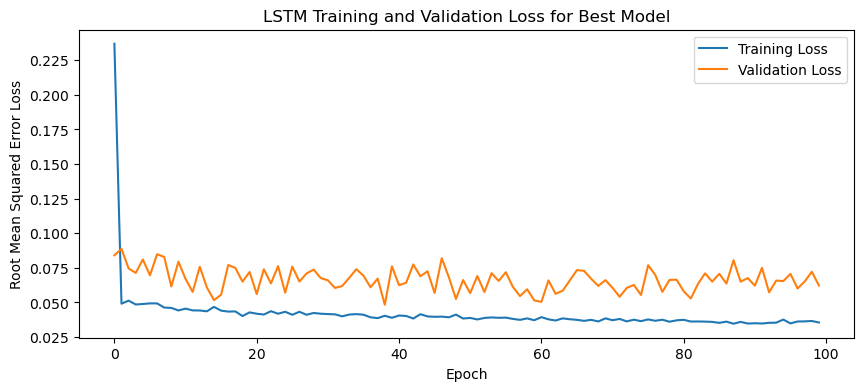

1/1 - 2s - loss: 0.0401 - 2s/epoch - 2s/step
Test Loss: 0.04008474200963974
1/1 [==============================] - 0s 42ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

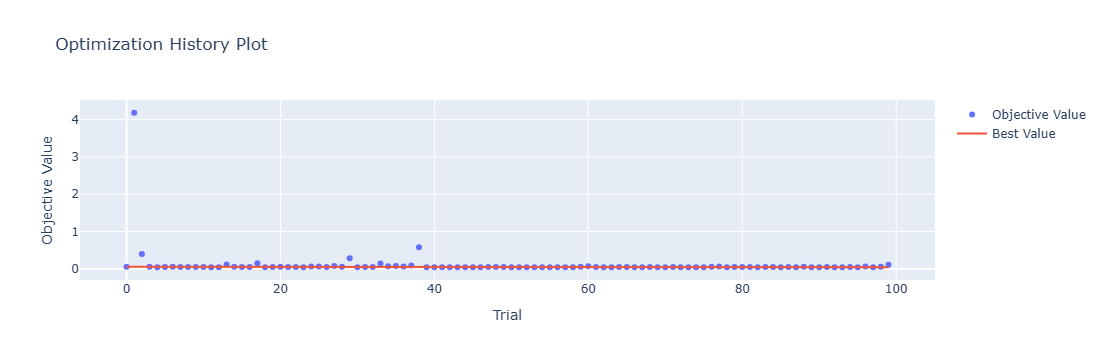

In [4]:
optuna.visualization.plot_optimization_history(study)

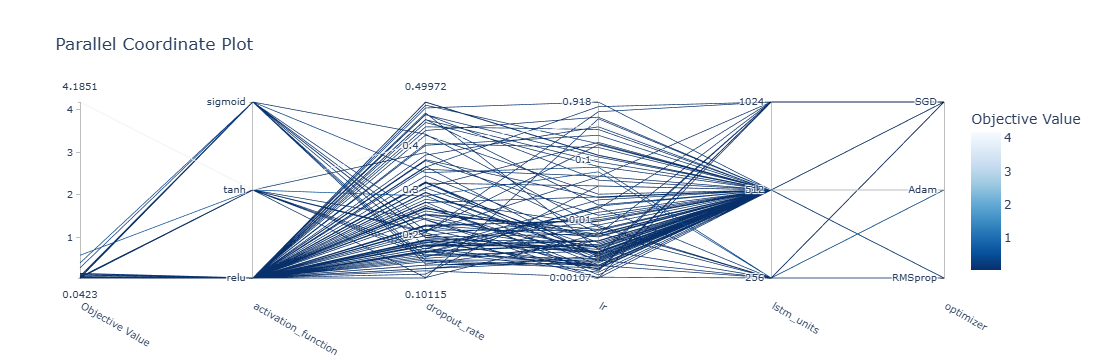

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

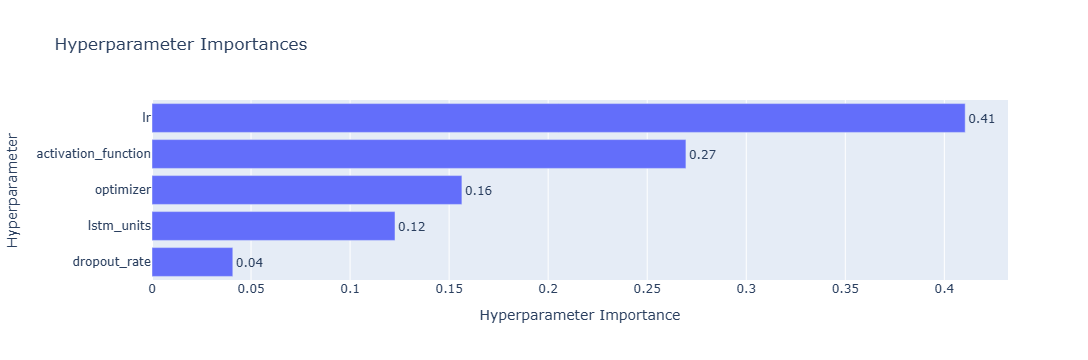

In [6]:
optuna.visualization.plot_param_importances(study)

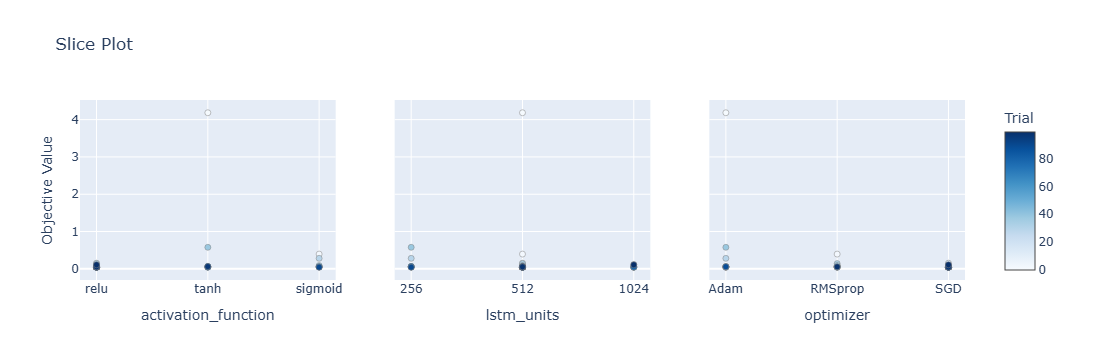

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

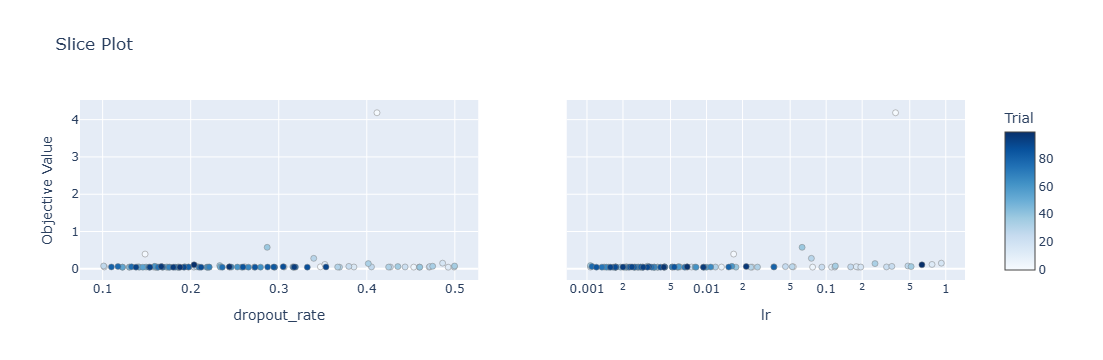

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 8s 33ms/step - loss: 0.2327 - accuracy: 0.4405 - mae: 0.2223 - rmse: 0.2327 - mape: 41.5401 - pearson: 0.5176 - val_loss: 0.0461 - val_accuracy: 0.9000 - val_mae: 0.0410 - val_rmse: 0.0461 - val_mape: 8.1196 - val_pearson: 0.7143
Epoch 2/100
84/84 [==============================] - 1s 17ms/step - loss: 0.0478 - accuracy: 0.8690 - mae: 0.0415 - rmse: 0.0478 - mape: 7.8405 - pearson: 0.7621 - val_loss: 0.0501 - val_accuracy: 0.9000 - val_mae: 0.0388 - val_rmse: 0.0501 - val_mape: 7.3942 - val_pearson: 0.7955
Epoch 3/100
84/84 [==============================] - 1s 17ms/step - loss: 0.0508 - accuracy: 0.8571 - mae: 0.0437 - rmse: 0.0508 - mape: 8.1635 - pearson: 0.7743 - val_loss: 0.0476 - val_accuracy: 0.9000 - val_mae: 0.0415 - val_rmse: 0.0476 - val_mape: 8.4241 - val_pearson: 0.7499
Epoch 4/100
84/84 [==============================] - 1s 17ms/step - loss: 0.0453 - accuracy: 0.8452 - mae: 0.0401 - rmse: 0.0453 - mape: 7.5829 - pearson

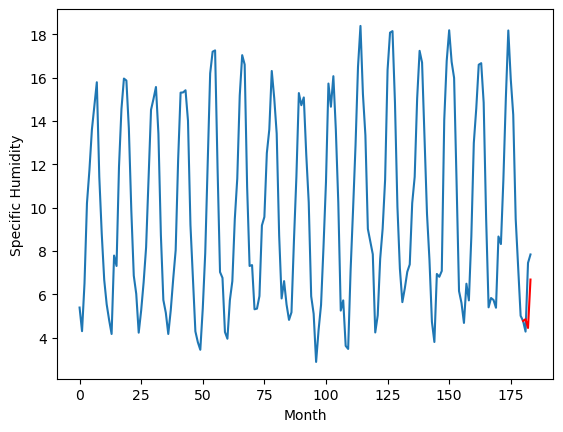

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.90		4.53		-0.37
5.61		4.21		-1.40
7.82		6.39		-1.43
[180, 181, 182, 183]
[7.05, 4.526577054709196, 4.211744605749845, 6.38644725009799]


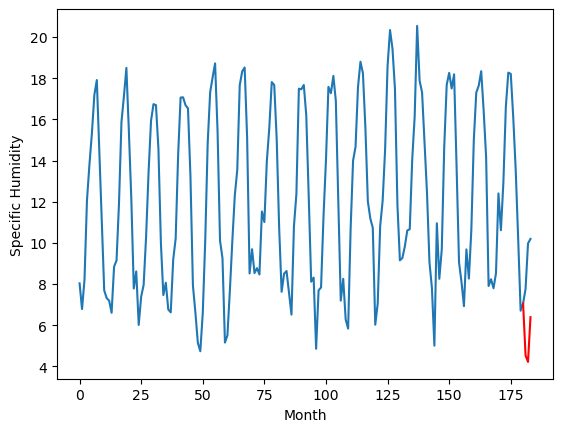

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.82		4.41		-0.41
4.97		4.13		-0.84
6.82		6.33		-0.49
[180, 181, 182, 183]
[5.06, 4.413080184310675, 4.134967772811652, 6.327714412063361]


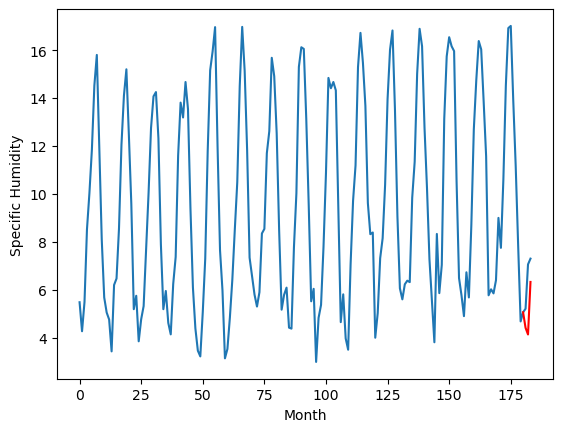

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.21		4.15		-0.06
4.12		3.89		-0.23
7.57		6.18		-1.39
[180, 181, 182, 183]
[7.05, 4.15321926061064, 3.8930808681622144, 6.179438747800886]


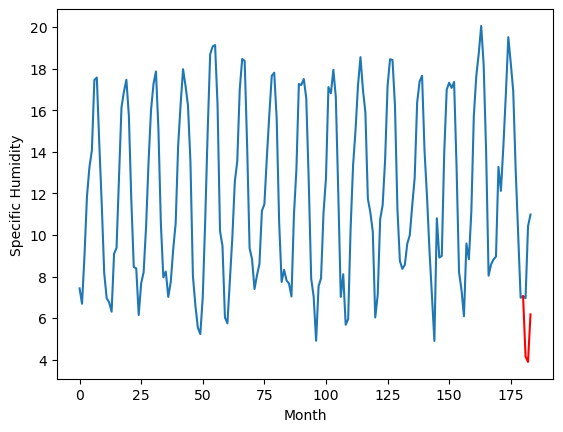

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.32		5.43		0.11
4.92		5.12		0.20
7.76		7.48		-0.28
[180, 181, 182, 183]
[5.2, 5.433868351727724, 5.121409359723329, 7.478868666440248]


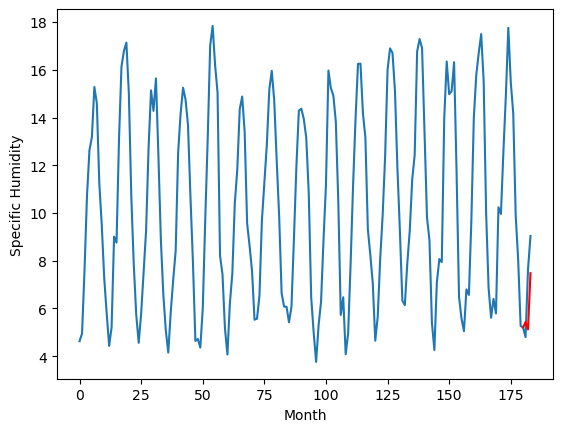

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.42		7.99		0.57
8.01		7.70		-0.31
9.58		9.89		0.31
[180, 181, 182, 183]
[5.16, 7.9865616548061364, 7.696352778673171, 9.88796645283699]


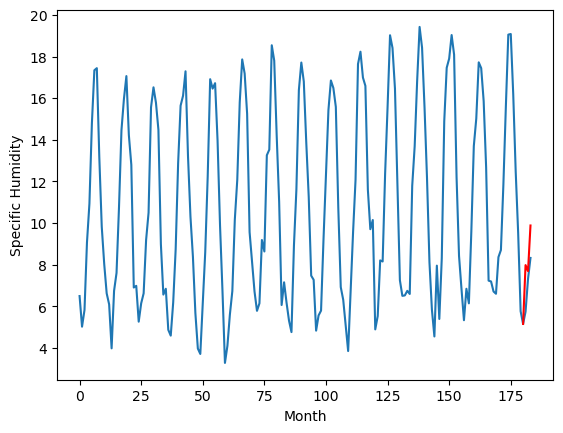

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.33		5.41		0.08
5.38		5.13		-0.25
6.97		7.25		0.28
[180, 181, 182, 183]
[4.05, 5.412832345366478, 5.128081973195076, 7.251882250905037]


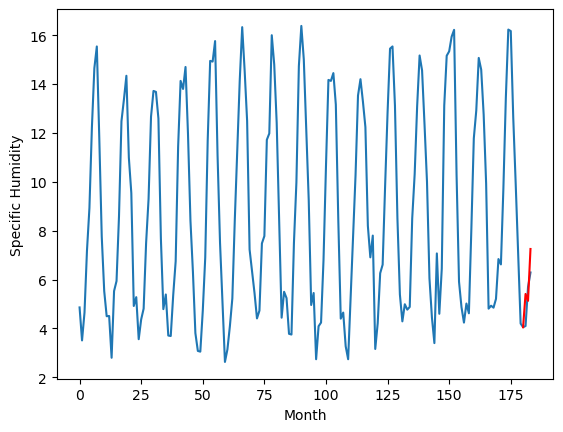

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.12		7.32		0.20
7.15		7.01		-0.14
8.77		9.10		0.33
[180, 181, 182, 183]
[3.64, 7.323358901143074, 7.014077253937721, 9.099146910309791]


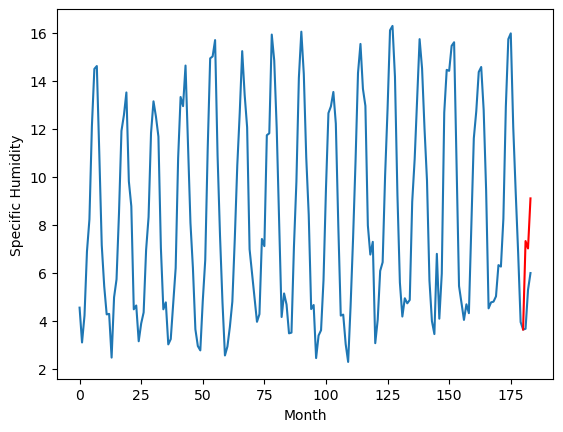

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.40		4.59		0.19
3.72		4.22		0.50
6.78		6.50		-0.28
[180, 181, 182, 183]
[3.46, 4.590924282670021, 4.215907861590385, 6.499886323809624]


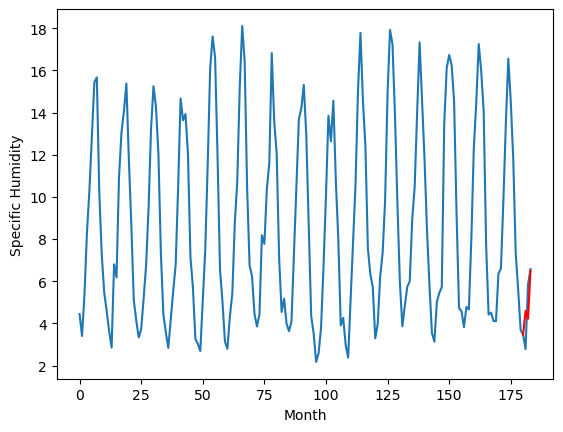

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.17		6.38		0.21
5.72		5.95		0.23
7.52		8.18		0.66
[180, 181, 182, 183]
[2.93, 6.383256942033768, 5.951082617044449, 8.181441217660904]


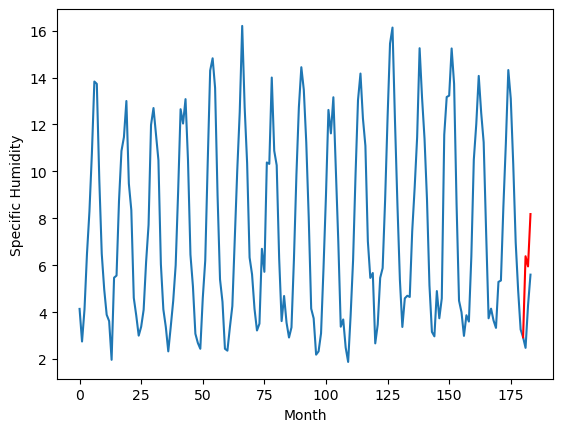

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.48		4.69		0.21
3.74		4.20		0.46
5.36		6.39		1.03
[180, 181, 182, 183]
[2.74, 4.686191350817681, 4.2034695154428485, 6.386012793183327]


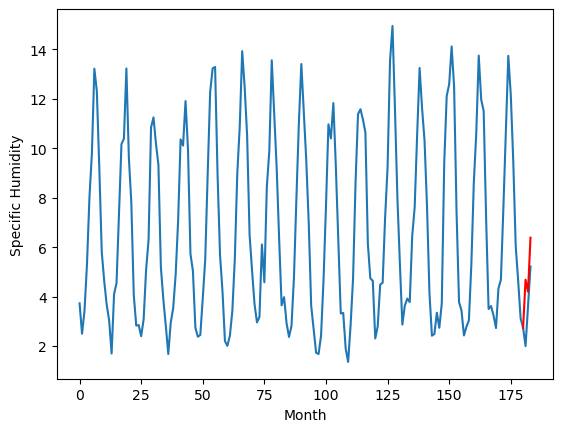

RangeIndex(start=1, stop=12, step=1)
[4.62, 4.899999999999999, 4.820000000000001, 4.209999999999998, 5.32, 7.42, 5.33, 7.119999999999999, 4.4, 6.170000000000001, 4.48]
[4.850710518322885, 4.526577054709196, 4.413080184310675, 4.15321926061064, 5.433868351727724, 7.9865616548061364, 5.412832345366478, 7.323358901143074, 4.590924282670021, 6.383256942033768, 4.686191350817681]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.62   4.850711
1                 1    4.90   4.526577
2                 2    4.82   4.413080
3                 3    4.21   4.153219
4                 4    5.32   5.433868
5                 5    7.42   7.986562
6                 6    5.33   5.412832
7                 7    7.12   7.323359
8                 8    4.40   4.590924
9                 9    6.17   6.383257
10               10    4.48   4.686191


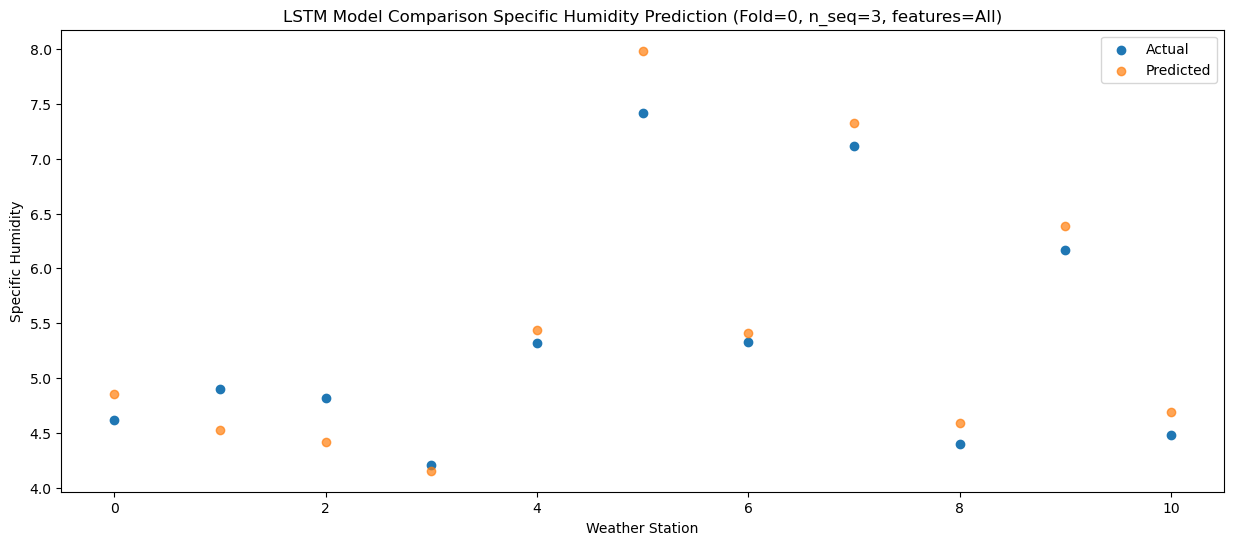

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    4.13   4.448848
1                 1    5.61   4.211745
2                 2    4.97   4.134968
3                 3    4.12   3.893081
4                 4    4.92   5.121409
5                 5    8.01   7.696353
6                 6    5.38   5.128082
7                 7    7.15   7.014077
8                 8    3.72   4.215908
9                 9    5.72   5.951083
10               10    3.74   4.203470


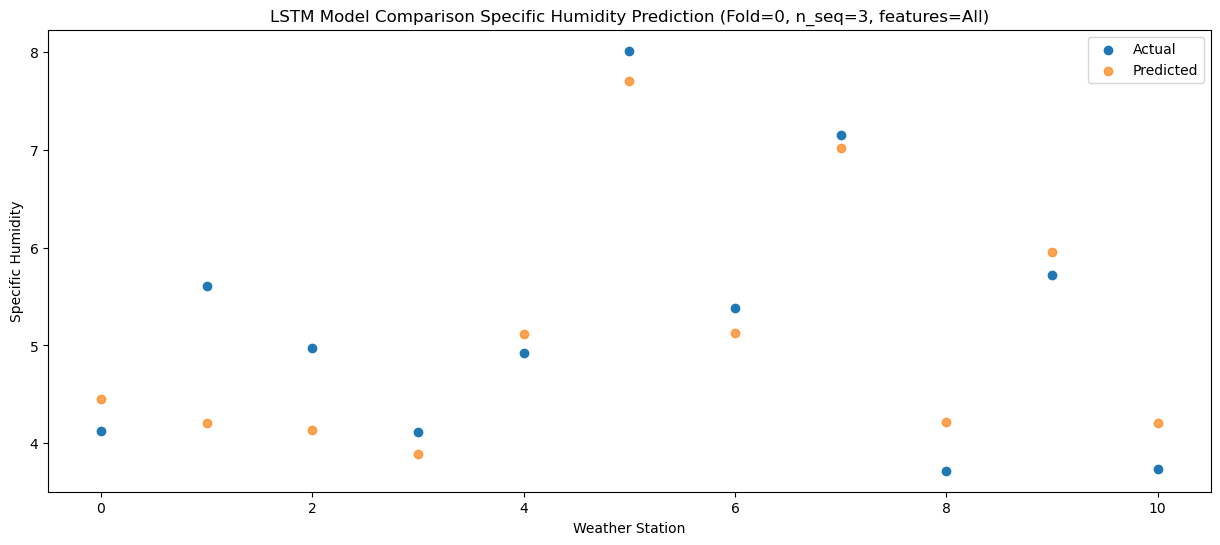

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    7.30   6.681915
1                 1    7.82   6.386447
2                 2    6.82   6.327714
3                 3    7.57   6.179439
4                 4    7.76   7.478869
5                 5    9.58   9.887966
6                 6    6.97   7.251882
7                 7    8.77   9.099147
8                 8    6.78   6.499886
9                 9    7.52   8.181441
10               10    5.36   6.386013


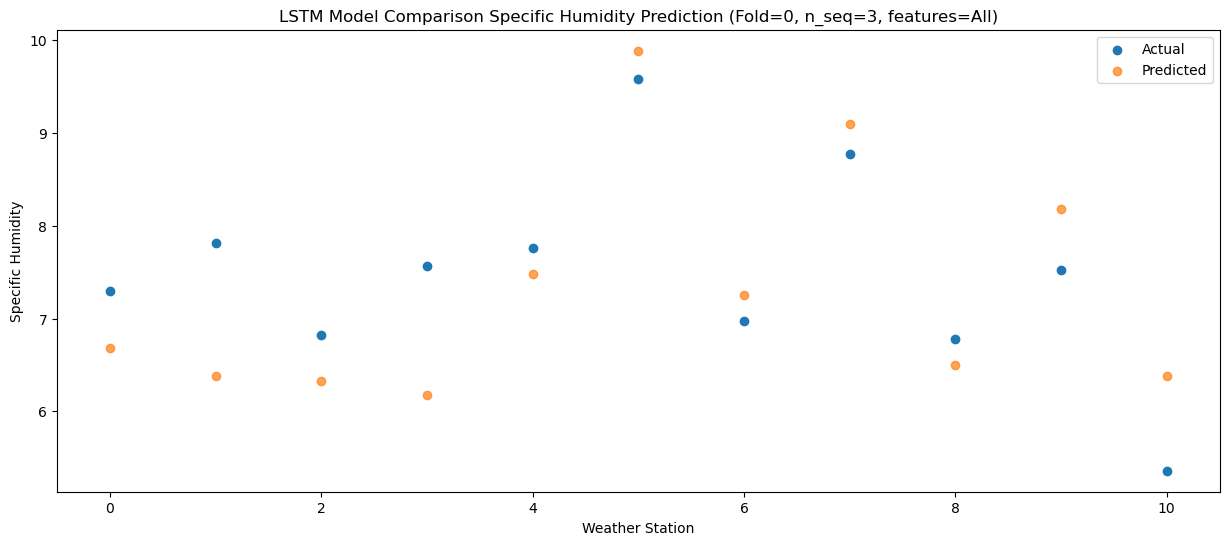

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (1, 1, 512)               5449728   
                                                                 
 dropout_10 (Dropout)        (1, 1, 512)               0         
                                                                 
 lstm_11 (LSTM)              (1, 512)                  2099200   
                                                                 
 dropout_11 (Dropout)        (1, 512)                  0         
                                                                 
 dense_15 (Dense)            (1, 256)                  131328    
                                                                 
 dense_16 (Dense)            (1, 128)                  32896     
                                                                 
 dense_17 (Dense)            (1, 3)                   

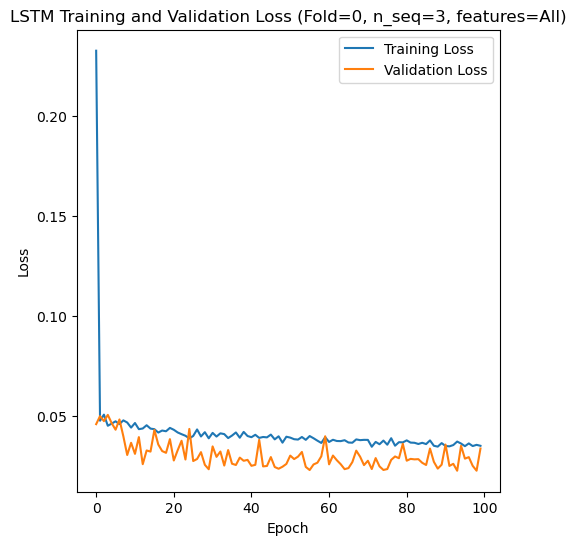

Epoch 1/100
84/84 [==============================] - 7s 35ms/step - loss: 0.1688 - accuracy: 0.4762 - mae: 0.1568 - rmse: 0.1688 - mape: 29.2747 - pearson: 0.5147 - val_loss: 0.0584 - val_accuracy: 0.9000 - val_mae: 0.0525 - val_rmse: 0.0584 - val_mape: 10.2544 - val_pearson: 0.8944
Epoch 2/100
84/84 [==============================] - 1s 16ms/step - loss: 0.0484 - accuracy: 0.8690 - mae: 0.0420 - rmse: 0.0484 - mape: 7.9881 - pearson: 0.7621 - val_loss: 0.0431 - val_accuracy: 0.9000 - val_mae: 0.0383 - val_rmse: 0.0431 - val_mape: 7.4215 - val_pearson: 0.9056
Epoch 3/100
84/84 [==============================] - 1s 17ms/step - loss: 0.0491 - accuracy: 0.8452 - mae: 0.0406 - rmse: 0.0491 - mape: 7.6169 - pearson: 0.7811 - val_loss: 0.0449 - val_accuracy: 0.9000 - val_mae: 0.0381 - val_rmse: 0.0449 - val_mape: 7.4686 - val_pearson: 0.9077
Epoch 4/100
84/84 [==============================] - 1s 17ms/step - loss: 0.0454 - accuracy: 0.8690 - mae: 0.0387 - rmse: 0.0454 - mape: 7.3136 - pearso

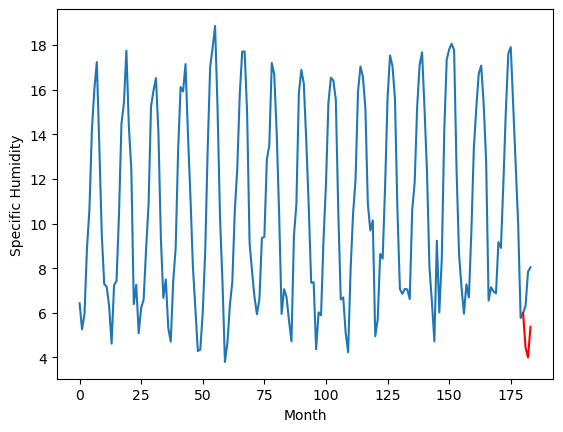

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.34		3.96		-0.38
4.53		3.54		-0.99
6.06		4.98		-1.08
[180, 181, 182, 183]
[4.15, 3.964425690174103, 3.5435303819179538, 4.976430453062058]


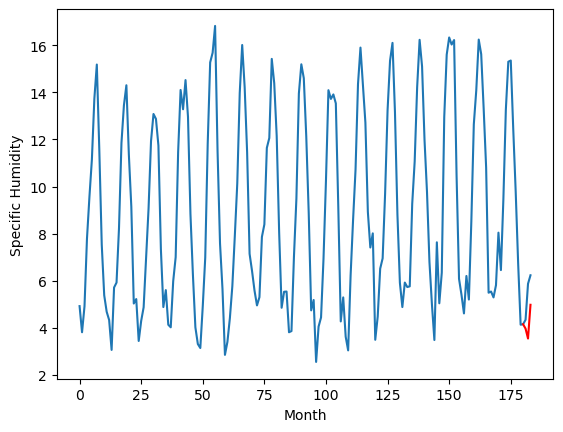

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.22		2.75		-0.47
3.22		2.35		-0.87
5.84		3.86		-1.98
[180, 181, 182, 183]
[5.12, 2.7493856620788573, 2.3546574187278746, 3.863474495410919]


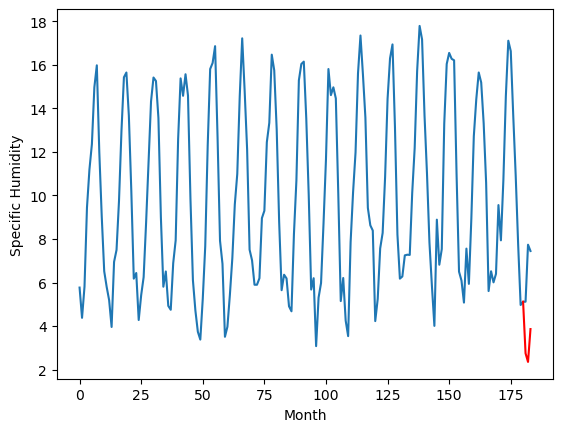

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.03		2.07		0.04
2.10		1.67		-0.43
4.74		3.20		-1.54
[180, 181, 182, 183]
[6.35, 2.068637306690216, 1.668429310321808, 3.202374155521393]


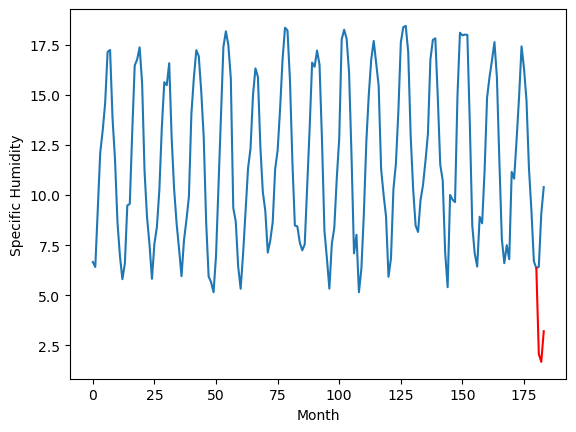

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.18		6.13		-0.05
6.22		5.73		-0.49
8.94		7.28		-1.66
[180, 181, 182, 183]
[6.08, 6.130979828834533, 5.731437944173813, 7.277571939229965]


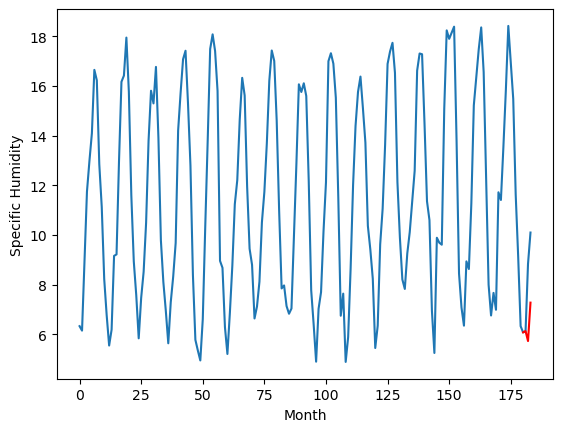

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.75		4.60		-1.15
5.12		4.14		-0.98
5.91		5.58		-0.33
[180, 181, 182, 183]
[3.92, 4.602017266750336, 4.142732752561569, 5.584051622152328]


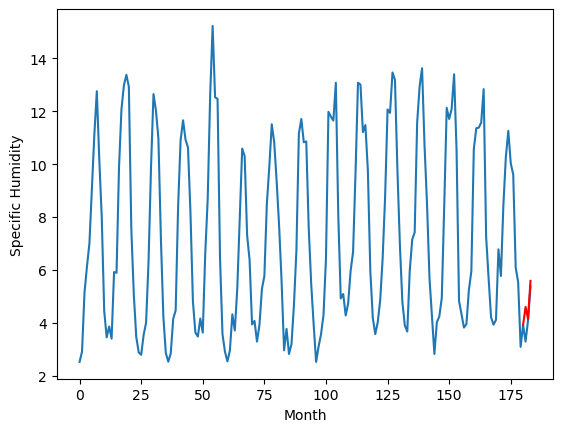

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.66		5.45		-0.21
5.78		5.04		-0.74
7.34		6.52		-0.82
[180, 181, 182, 183]
[4.16, 5.447067309617996, 5.039575536251068, 6.516097028255462]


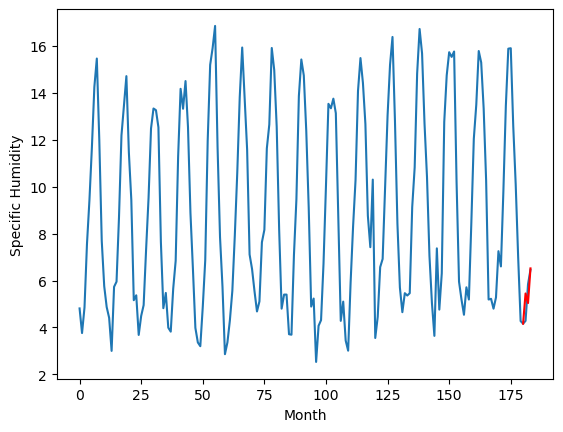

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.53		6.35		-0.18
6.01		5.92		-0.09
8.74		7.47		-1.27
[180, 181, 182, 183]
[3.84, 6.346209261417389, 5.918450716733933, 7.466233137845993]


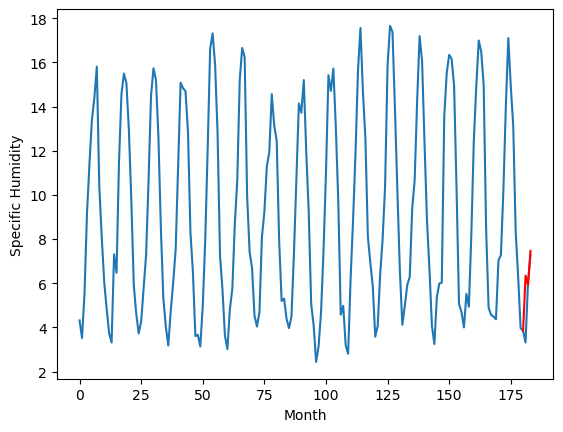

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.49		6.03		-0.46
5.68		5.57		-0.11
8.29		7.11		-1.18
[180, 181, 182, 183]
[3.73, 6.033035235404968, 5.5736211705207825, 7.111954228878021]


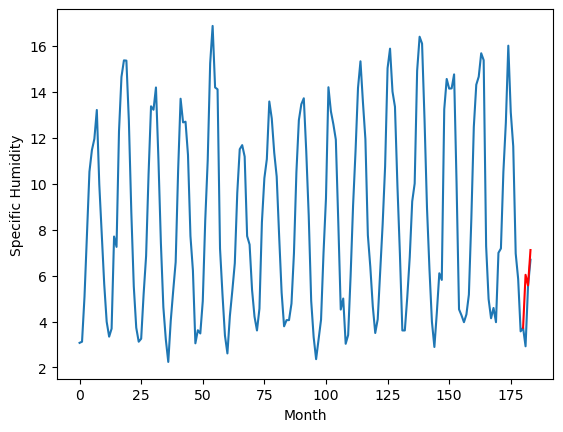

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.71		2.22		-0.49
1.97		1.72		-0.25
3.79		3.20		-0.59
[180, 181, 182, 183]
[2.83, 2.218461353778839, 1.7236648094654083, 3.2002530586719513]


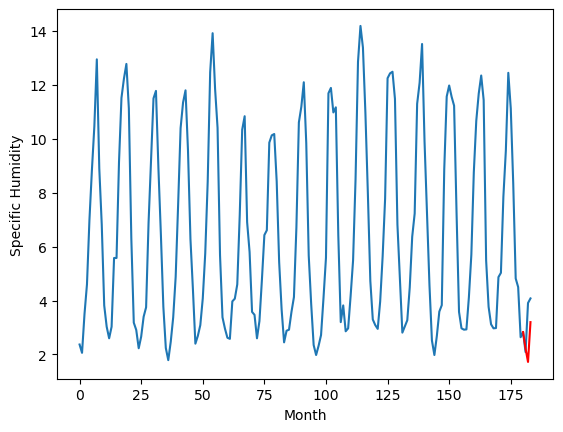

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.08		4.42		0.34
4.12		3.89		-0.23
5.36		5.25		-0.11
[180, 181, 182, 183]
[2.69, 4.416346815824508, 3.8933534300327297, 5.249260512590408]


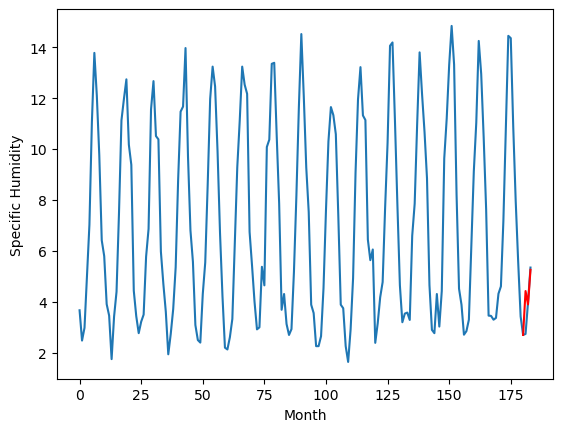

RangeIndex(start=1, stop=12, step=1)
[5.03, 4.340000000000002, 3.2199999999999998, 2.0299999999999994, 6.18, 5.75, 5.66, 6.529999999999999, 6.49, 2.7100000000000004, 4.079999999999999]
[4.4446601545810696, 3.964425690174103, 2.7493856620788573, 2.068637306690216, 6.130979828834533, 4.602017266750336, 5.447067309617996, 6.346209261417389, 6.033035235404968, 2.218461353778839, 4.416346815824508]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    5.03   4.444660
1                 1    4.34   3.964426
2                 2    3.22   2.749386
3                 3    2.03   2.068637
4                 4    6.18   6.130980
5                 5    5.75   4.602017
6                 6    5.66   5.447067
7                 7    6.53   6.346209
8                 8    6.49   6.033035
9                 9    2.71   2.218461
10               10    4.08   4.416347


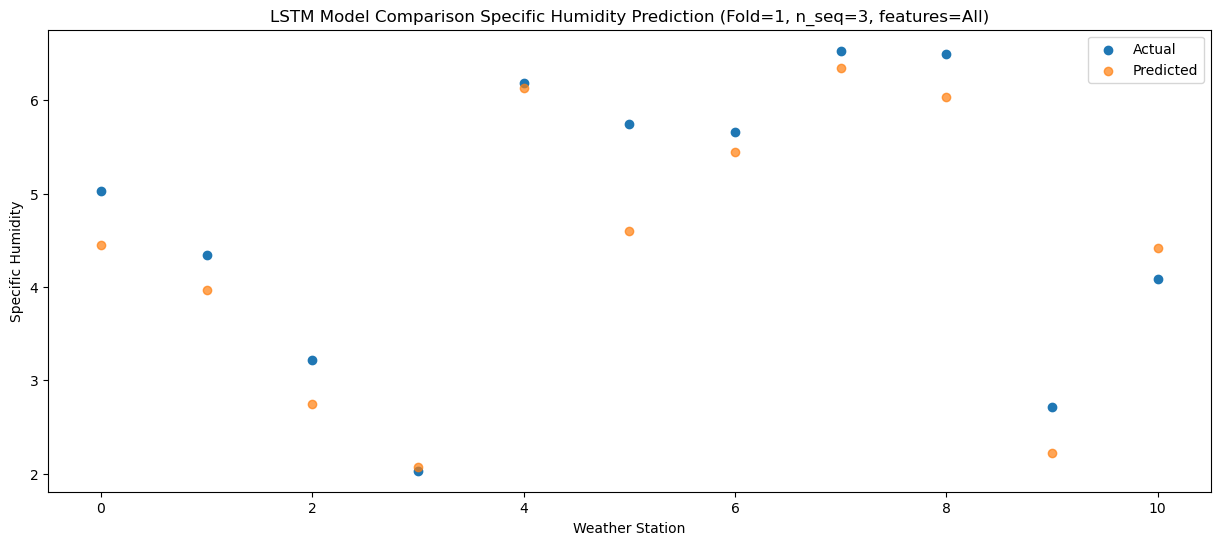

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    5.35   4.002039
1                 1    4.53   3.543530
2                 2    3.22   2.354657
3                 3    2.10   1.668429
4                 4    6.22   5.731438
5                 5    5.12   4.142733
6                 6    5.78   5.039576
7                 7    6.01   5.918451
8                 8    5.68   5.573621
9                 9    1.97   1.723665
10               10    4.12   3.893353


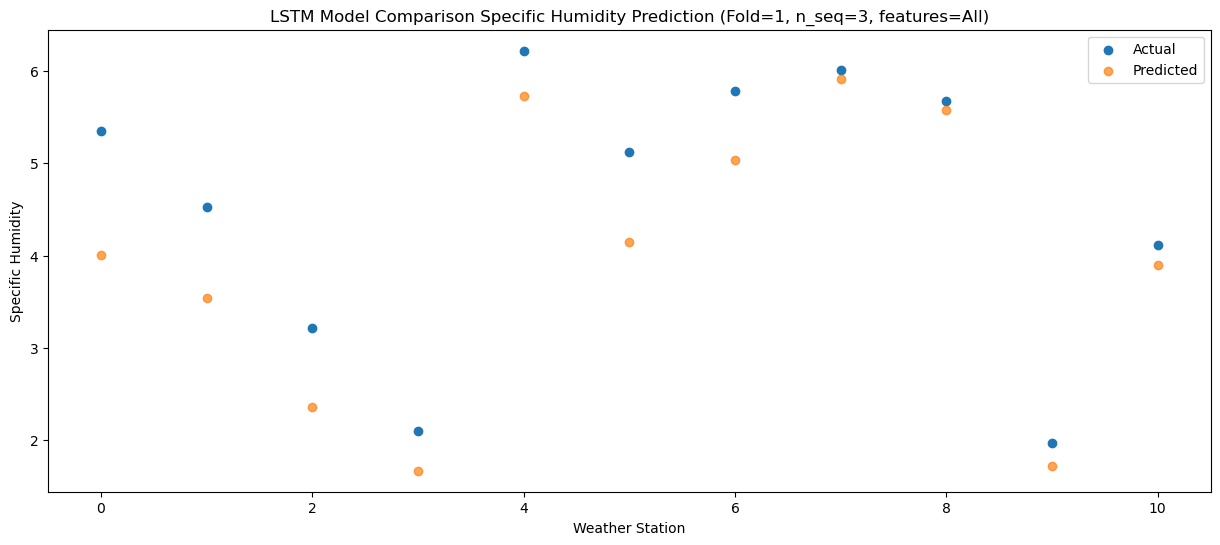

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    6.88   5.372997
1                 1    6.06   4.976430
2                 2    5.84   3.863474
3                 3    4.74   3.202374
4                 4    8.94   7.277572
5                 5    5.91   5.584052
6                 6    7.34   6.516097
7                 7    8.74   7.466233
8                 8    8.29   7.111954
9                 9    3.79   3.200253
10               10    5.36   5.249261


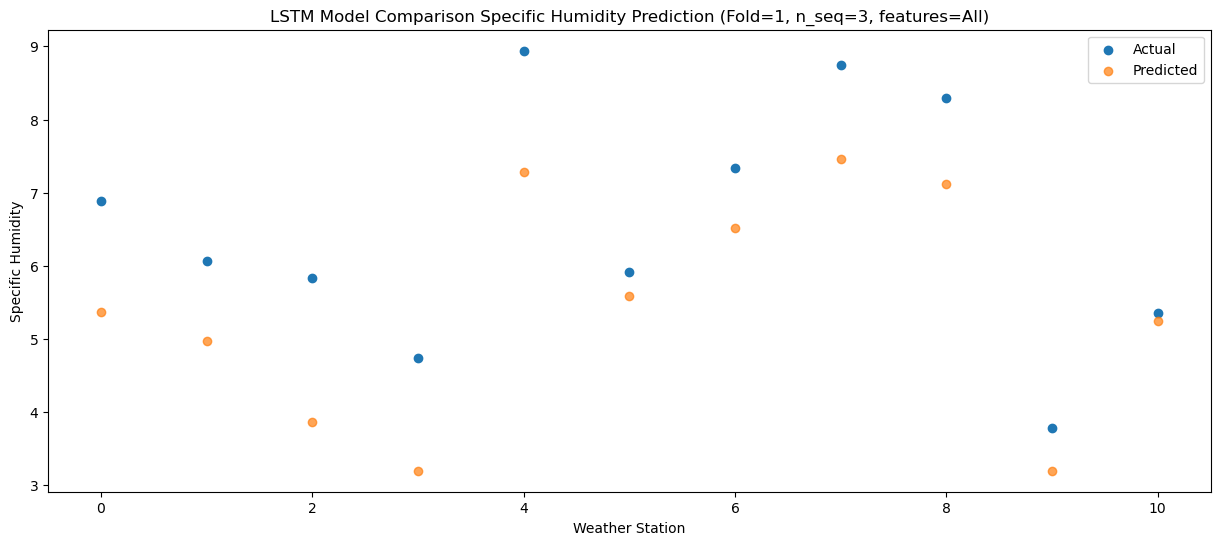

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (1, 1, 512)               5449728   
                                                                 
 dropout_12 (Dropout)        (1, 1, 512)               0         
                                                                 
 lstm_13 (LSTM)              (1, 512)                  2099200   
                                                                 
 dropout_13 (Dropout)        (1, 512)                  0         
                                                                 
 dense_18 (Dense)            (1, 256)                  131328    
                                                                 
 dense_19 (Dense)            (1, 128)                  32896     
                                                                 
 dense_20 (Dense)            (1, 3)                   

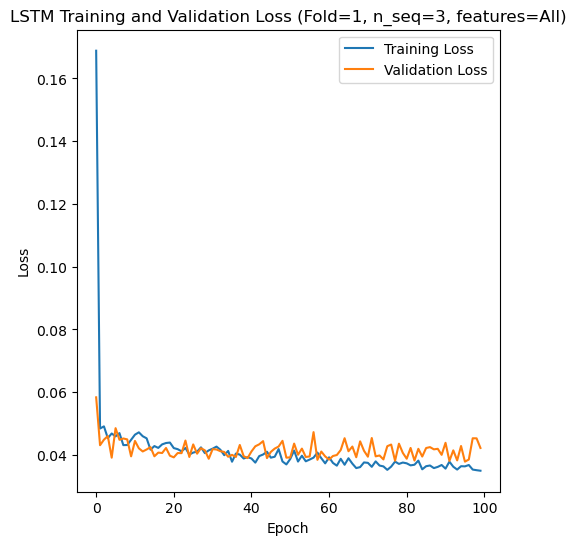

Epoch 1/100
84/84 [==============================] - 7s 34ms/step - loss: 0.2361 - accuracy: 0.5476 - mae: 0.2290 - rmse: 0.2361 - mape: 42.9997 - pearson: 0.6031 - val_loss: 0.0283 - val_accuracy: 1.0000 - val_mae: 0.0249 - val_rmse: 0.0283 - val_mape: 4.6807 - val_pearson: 0.9017
Epoch 2/100
84/84 [==============================] - 1s 18ms/step - loss: 0.0517 - accuracy: 0.8690 - mae: 0.0440 - rmse: 0.0517 - mape: 8.3767 - pearson: 0.7484 - val_loss: 0.0399 - val_accuracy: 1.0000 - val_mae: 0.0336 - val_rmse: 0.0399 - val_mape: 6.6104 - val_pearson: 0.7154
Epoch 3/100
84/84 [==============================] - 2s 18ms/step - loss: 0.0503 - accuracy: 0.8690 - mae: 0.0428 - rmse: 0.0503 - mape: 8.0889 - pearson: 0.7542 - val_loss: 0.0478 - val_accuracy: 1.0000 - val_mae: 0.0420 - val_rmse: 0.0478 - val_mape: 8.0724 - val_pearson: 0.8774
Epoch 4/100
84/84 [==============================] - 1s 18ms/step - loss: 0.0476 - accuracy: 0.8929 - mae: 0.0409 - rmse: 0.0476 - mape: 7.6413 - pearson

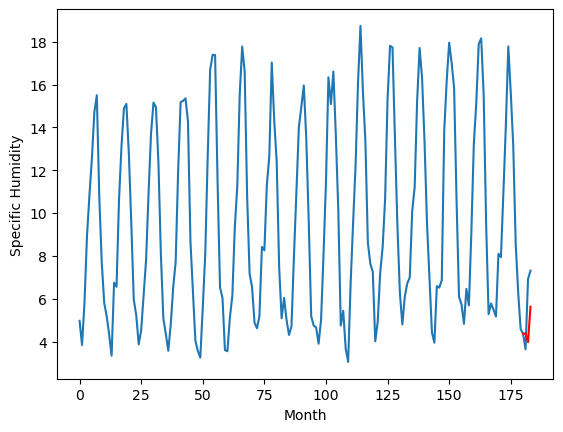

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.84		1.72		-0.12
1.16		1.28		0.12
3.01		2.87		-0.14
[180, 181, 182, 183]
[2.82, 1.7214883857965468, 1.278925328850746, 2.8723218733072278]


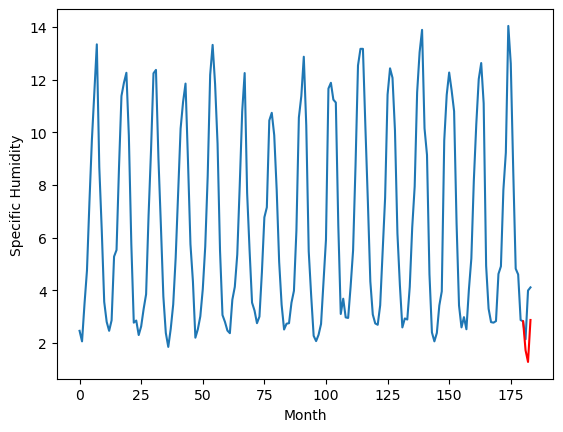

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.53		4.85		-0.68
7.66		4.51		-3.15
7.88		6.11		-1.77
[180, 181, 182, 183]
[9.16, 4.8530699545145035, 4.512357138991356, 6.106897377371788]


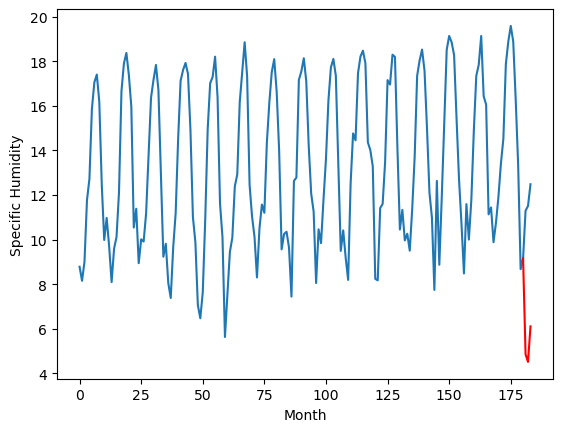

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.98		4.77		0.79
4.15		4.37		0.22
4.79		5.82		1.03
[180, 181, 182, 183]
[2.44, 4.770685700178146, 4.373817679882049, 5.823322651386261]


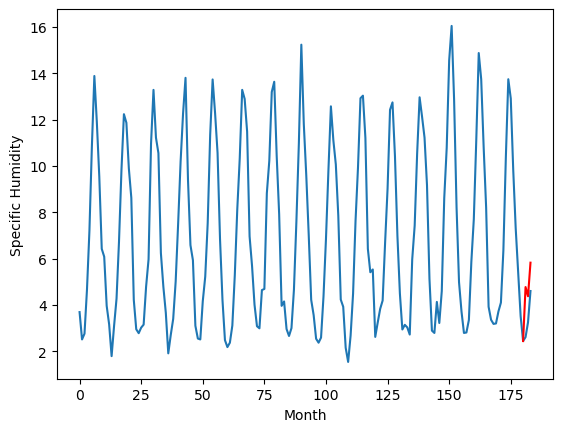

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.10		4.77		-0.33
5.08		4.46		-0.62
8.37		6.10		-2.27
[180, 181, 182, 183]
[6.65, 4.7672089797258375, 4.464003042578697, 6.095772818922996]


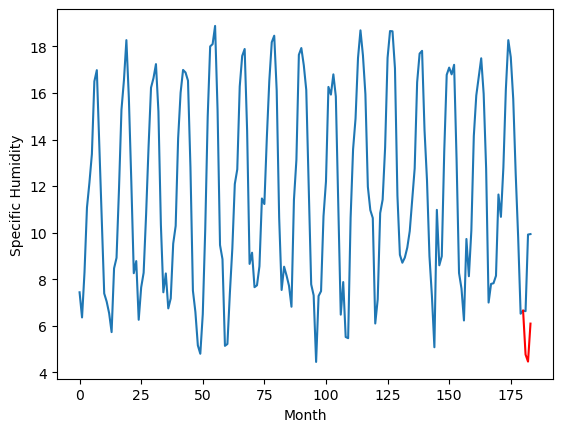

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.33		2.29		-0.04
2.28		1.97		-0.31
5.27		3.60		-1.67
[180, 181, 182, 183]
[6.19, 2.2913312977552414, 1.9737863904237747, 3.6040686732530594]


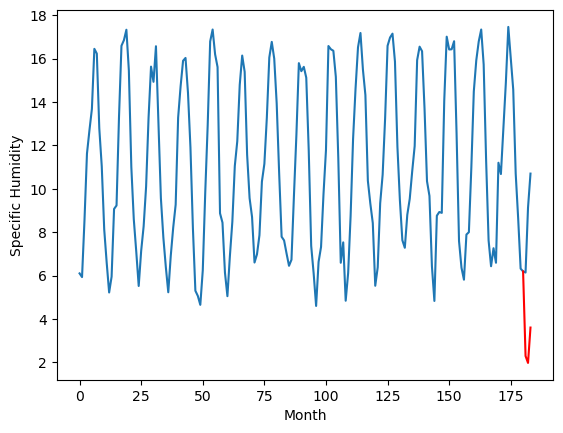

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.68		8.65		-0.03
8.35		8.31		-0.04
11.21		9.99		-1.22
[180, 181, 182, 183]
[4.78, 8.650123133063316, 8.309096141457557, 9.993825359940528]


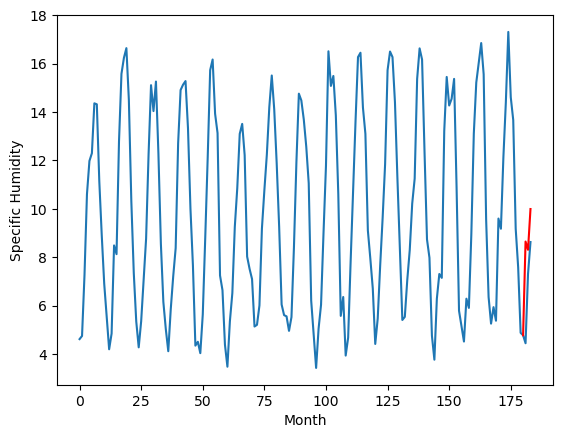

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.97		3.55		-0.42
3.84		3.16		-0.68
3.93		4.66		0.73
[180, 181, 182, 183]
[2.61, 3.5453205728530883, 3.1635750555992126, 4.662648680210113]


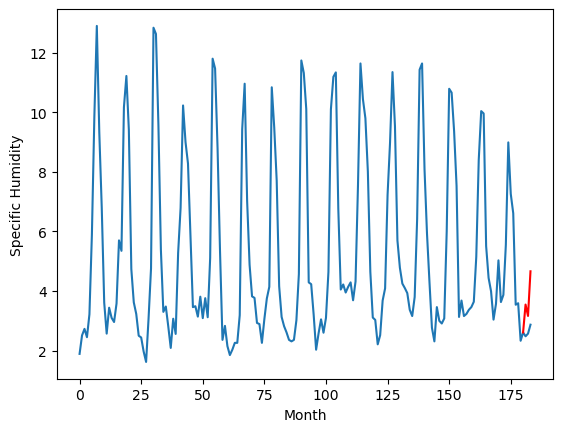

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.29		7.28		-1.01
8.82		6.85		-1.97
8.93		8.20		-0.73
[180, 181, 182, 183]
[4.6, 7.282854201793671, 6.846204909086228, 8.19511881709099]


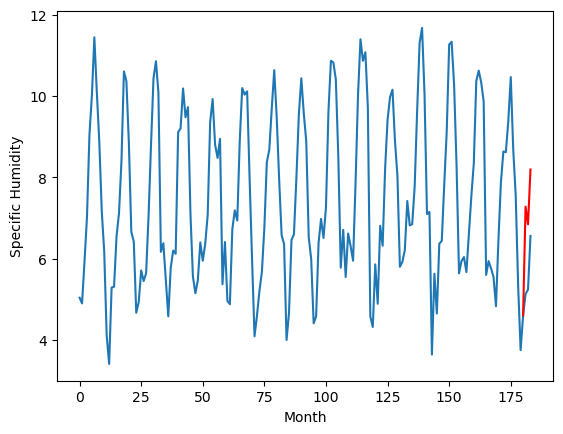

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.98		5.90		-0.08
6.05		5.54		-0.51
7.78		7.06		-0.72
[180, 181, 182, 183]
[4.27, 5.901788434386253, 5.540911516547203, 7.05537768304348]


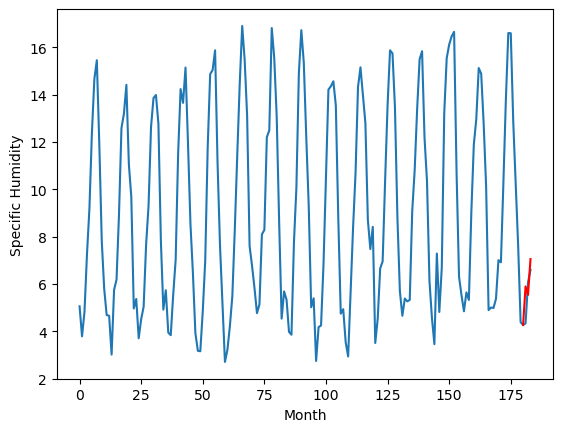

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.63		4.39		-0.24
4.87		4.03		-0.84
5.90		5.57		-0.33
[180, 181, 182, 183]
[3.91, 4.390170882344246, 4.026284406781197, 5.570077965855599]


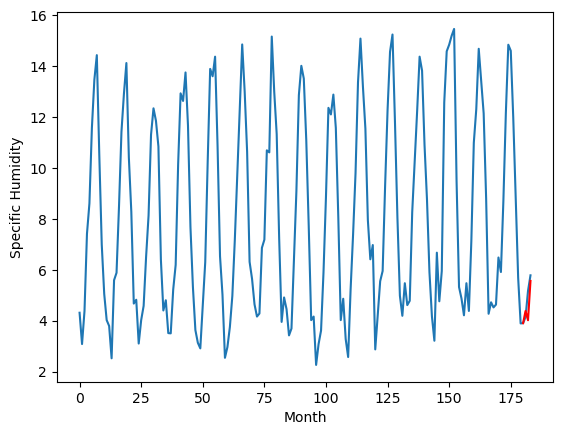

RangeIndex(start=1, stop=12, step=1)
[4.390000000000001, 1.8399999999999992, 5.529999999999999, 3.9799999999999995, 5.1, 2.33, 8.68, 3.9700000000000006, 8.29, 5.9799999999999995, 4.63]
[4.3867963802814485, 1.7214883857965468, 4.8530699545145035, 4.770685700178146, 4.7672089797258375, 2.2913312977552414, 8.650123133063316, 3.5453205728530883, 7.282854201793671, 5.901788434386253, 4.390170882344246]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.39   4.386796
1                 1    1.84   1.721488
2                 2    5.53   4.853070
3                 3    3.98   4.770686
4                 4    5.10   4.767209
5                 5    2.33   2.291331
6                 6    8.68   8.650123
7                 7    3.97   3.545321
8                 8    8.29   7.282854
9                 9    5.98   5.901788
10               10    4.63   4.390171


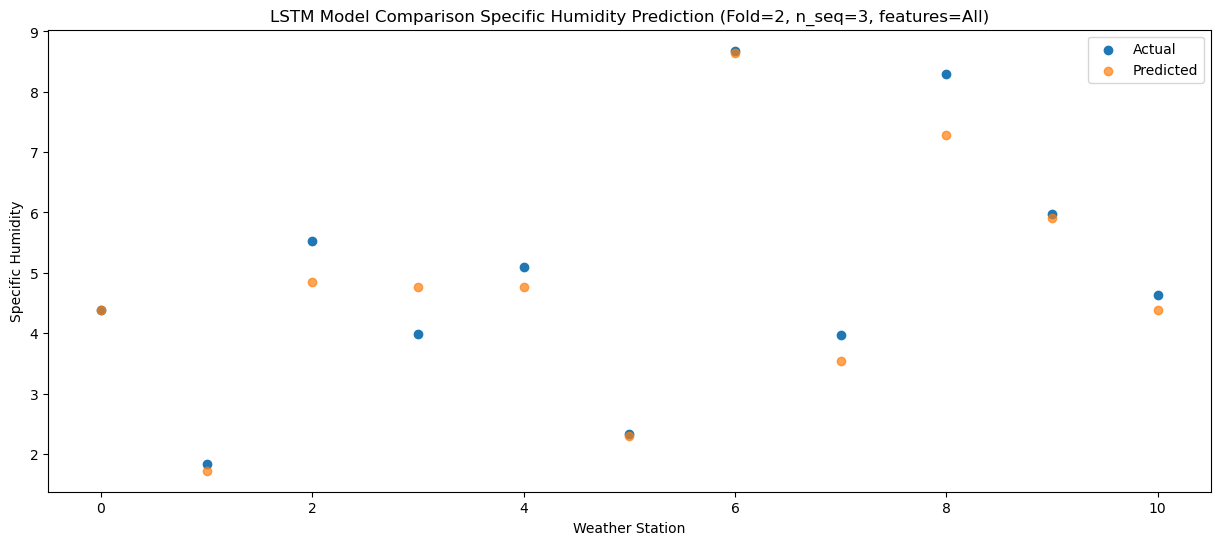

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    3.67   3.971501
1                 1    1.16   1.278925
2                 2    7.66   4.512357
3                 3    4.15   4.373818
4                 4    5.08   4.464003
5                 5    2.28   1.973786
6                 6    8.35   8.309096
7                 7    3.84   3.163575
8                 8    8.82   6.846205
9                 9    6.05   5.540912
10               10    4.87   4.026284


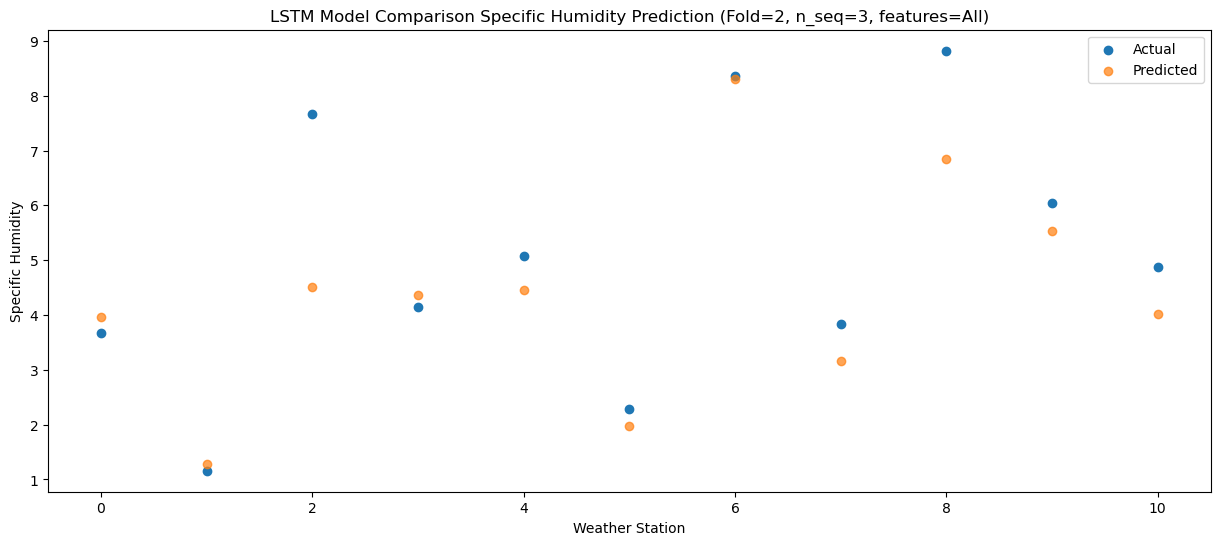

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    6.95   5.628828
1                 1    3.01   2.872322
2                 2    7.88   6.106897
3                 3    4.79   5.823323
4                 4    8.37   6.095773
5                 5    5.27   3.604069
6                 6   11.21   9.993825
7                 7    3.93   4.662649
8                 8    8.93   8.195119
9                 9    7.78   7.055378
10               10    5.90   5.570078


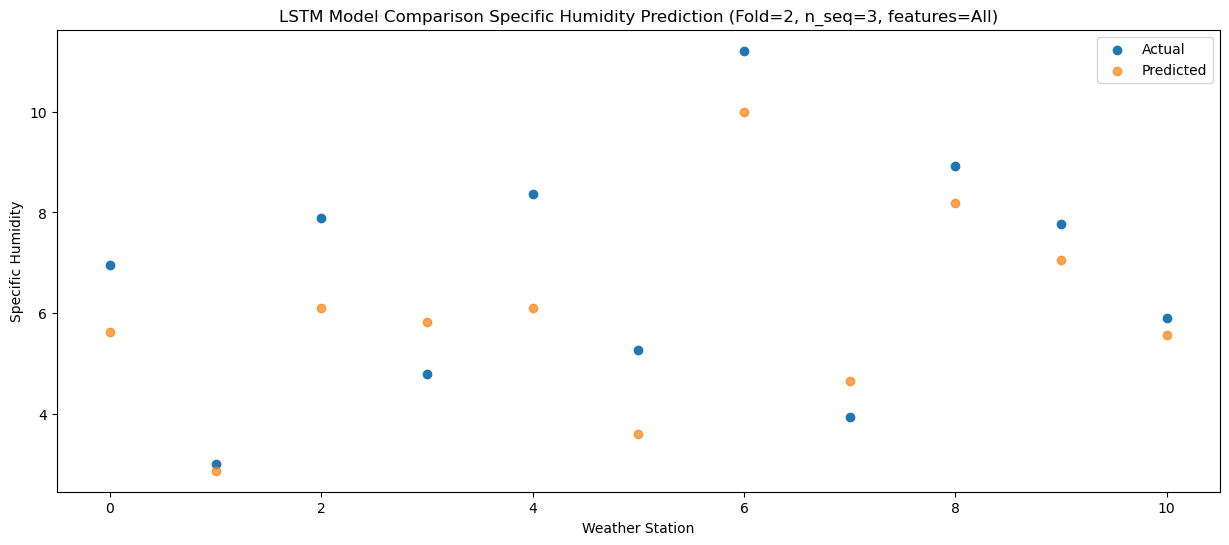

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (1, 1, 512)               5449728   
                                                                 
 dropout_14 (Dropout)        (1, 1, 512)               0         
                                                                 
 lstm_15 (LSTM)              (1, 512)                  2099200   
                                                                 
 dropout_15 (Dropout)        (1, 512)                  0         
                                                                 
 dense_21 (Dense)            (1, 256)                  131328    
                                                                 
 dense_22 (Dense)            (1, 128)                  32896     
                                                                 
 dense_23 (Dense)            (1, 3)                   

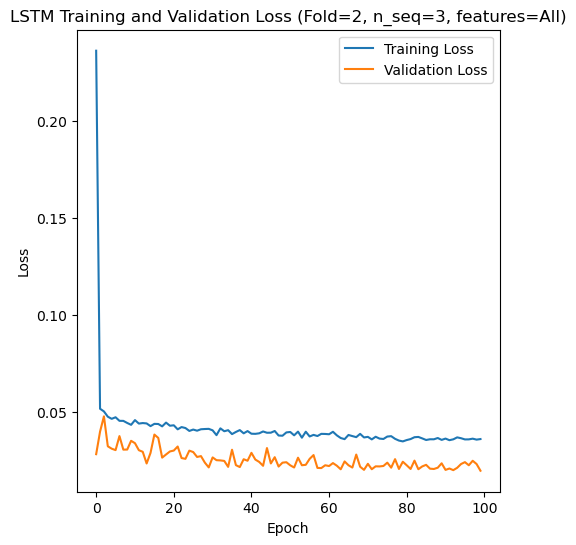

Epoch 1/100
84/84 [==============================] - 7s 31ms/step - loss: 0.2471 - accuracy: 0.7738 - mae: 0.2410 - rmse: 0.2471 - mape: 45.2212 - pearson: 0.6594 - val_loss: 0.0547 - val_accuracy: 0.8000 - val_mae: 0.0457 - val_rmse: 0.0547 - val_mape: 9.3722 - val_pearson: 0.8153
Epoch 2/100
84/84 [==============================] - 1s 16ms/step - loss: 0.0452 - accuracy: 0.8929 - mae: 0.0393 - rmse: 0.0452 - mape: 7.3764 - pearson: 0.8409 - val_loss: 0.0453 - val_accuracy: 0.8000 - val_mae: 0.0384 - val_rmse: 0.0453 - val_mape: 7.2497 - val_pearson: 0.8451
Epoch 3/100
84/84 [==============================] - 1s 16ms/step - loss: 0.0493 - accuracy: 0.8929 - mae: 0.0413 - rmse: 0.0493 - mape: 7.5991 - pearson: 0.8037 - val_loss: 0.0288 - val_accuracy: 0.8000 - val_mae: 0.0263 - val_rmse: 0.0288 - val_mape: 5.1339 - val_pearson: 0.8481
Epoch 4/100
84/84 [==============================] - 1s 16ms/step - loss: 0.0479 - accuracy: 0.9048 - mae: 0.0406 - rmse: 0.0479 - mape: 7.5491 - pearson

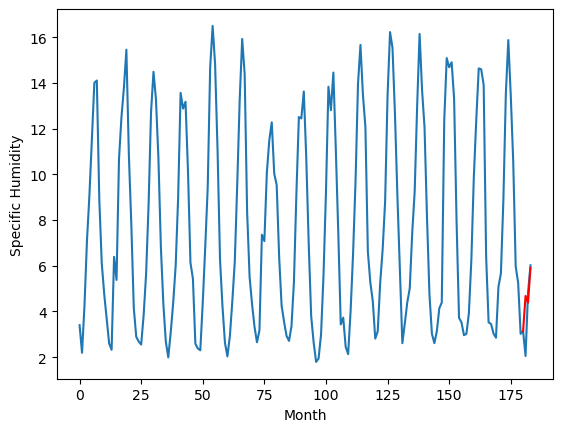

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.27		3.45		-0.82
6.26		3.29		-2.97
6.23		4.76		-1.47
[180, 181, 182, 183]
[7.79, 3.445327146053314, 3.291926411986351, 4.760149983763695]


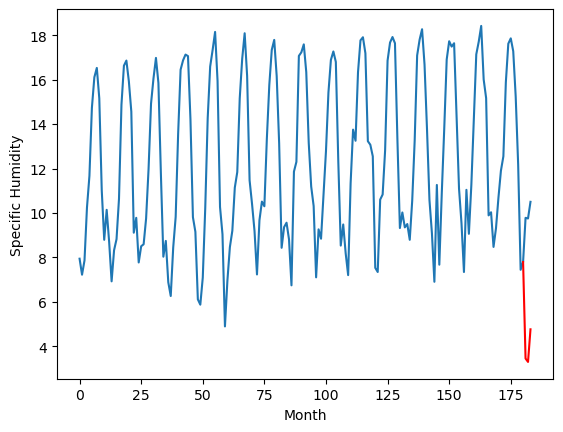

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.87		3.52		-0.35
3.75		3.39		-0.36
6.81		4.98		-1.83
[180, 181, 182, 183]
[5.03, 3.524676423072815, 3.387777786254883, 4.978224496841431]


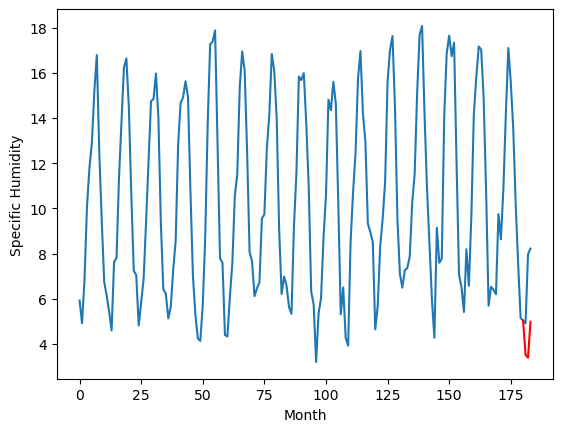

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.73		3.38		-0.35
3.41		3.22		-0.19
6.07		4.89		-1.18
[180, 181, 182, 183]
[4.41, 3.3828926944732665, 3.2168381625413893, 4.885102551579475]


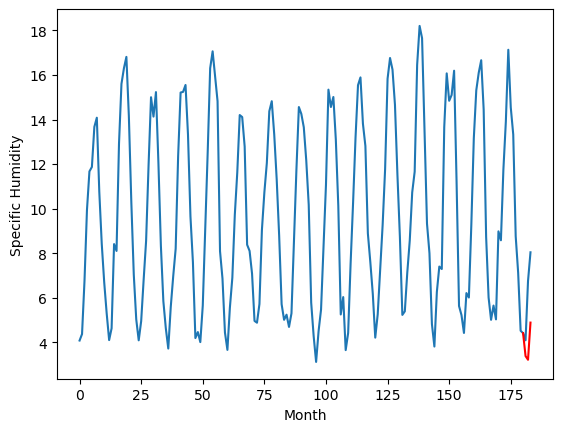

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.36		2.94		-0.42
2.91		2.77		-0.14
5.49		4.47		-1.02
[180, 181, 182, 183]
[4.29, 2.9447953343391418, 2.7714043349027633, 4.468887040019036]


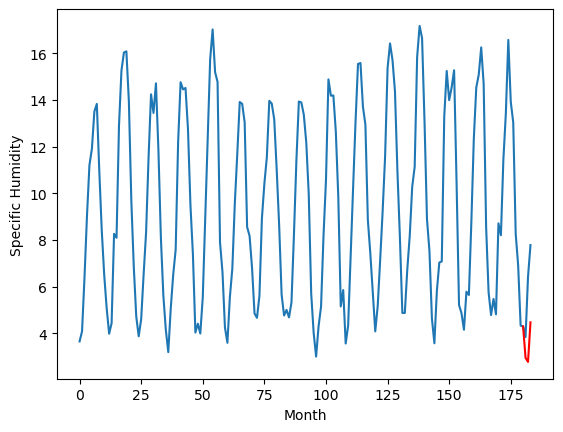

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.64		7.48		-1.16
8.00		7.28		-0.72
9.49		8.86		-0.63
[180, 181, 182, 183]
[3.47, 7.480302693843842, 7.281507911682129, 8.85978669166565]


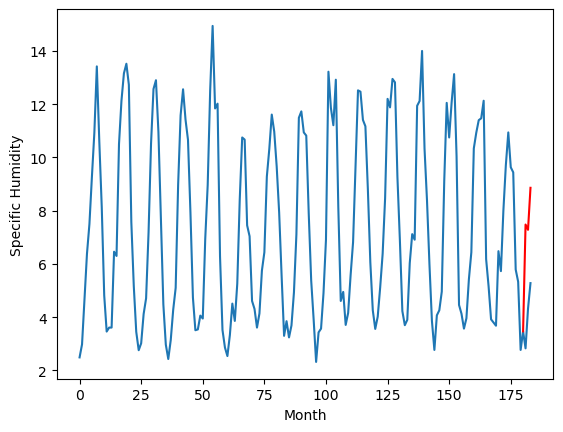

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.80		5.44		-0.36
6.05		5.30		-0.75
7.76		6.87		-0.89
[180, 181, 182, 183]
[4.52, 5.437921566963196, 5.298083407878876, 6.8659189772605895]


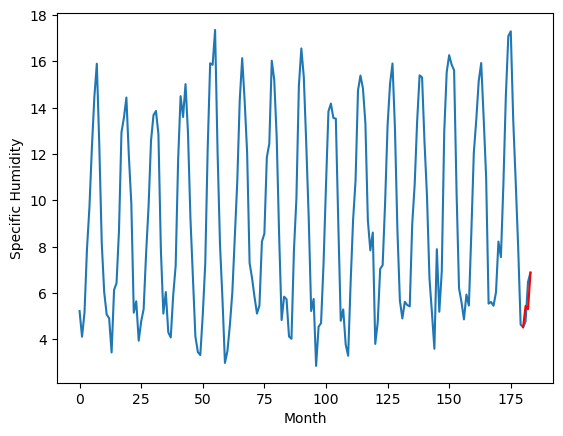

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.93		3.60		-0.33
3.30		3.42		0.12
5.67		5.08		-0.59
[180, 181, 182, 183]
[3.4, 3.5954407918453217, 3.4161403048038483, 5.084561334848404]


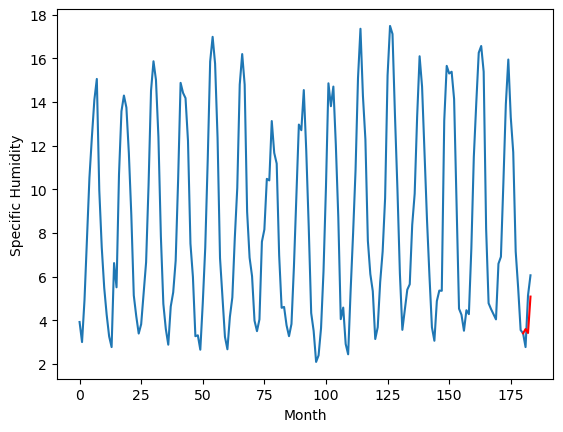

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.30		3.09		-0.21
2.73		2.83		0.10
4.67		4.42		-0.25
[180, 181, 182, 183]
[2.82, 3.094610059261322, 2.8349391162395476, 4.4243929326534275]


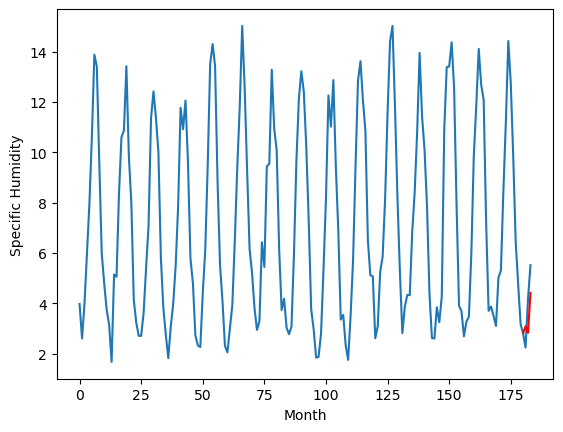

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.17		1.92		-0.25
1.53		1.63		0.10
3.90		3.24		-0.66
[180, 181, 182, 183]
[2.86, 1.9223357343673708, 1.627050271034241, 3.241096248626709]


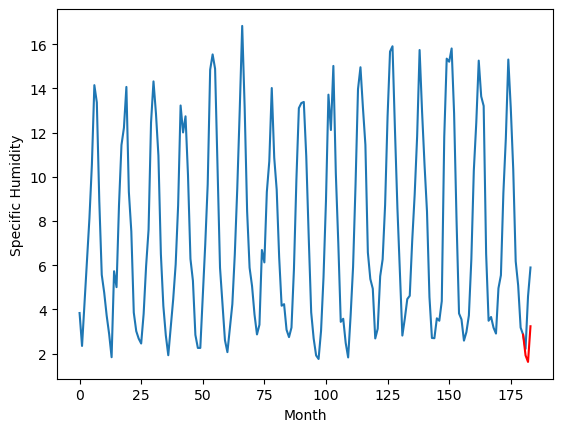

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.84		4.59		-0.25
4.27		4.25		-0.02
5.56		5.70		0.14
[180, 181, 182, 183]
[2.61, 4.58855286359787, 4.2452842903137205, 5.700193257331848]


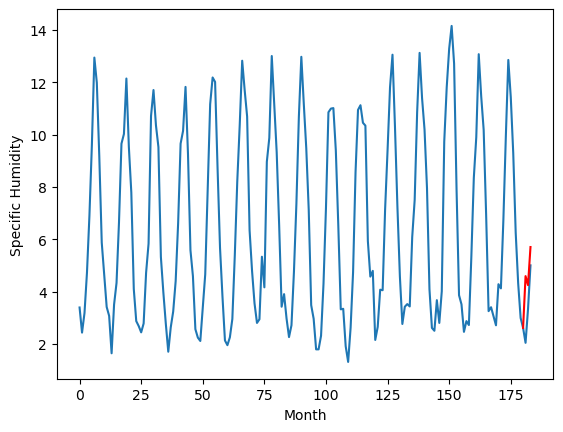

RangeIndex(start=1, stop=12, step=1)
[5.34, 4.269999999999999, 3.870000000000001, 3.7300000000000004, 3.3600000000000003, 8.64, 5.8, 3.93, 3.3000000000000003, 2.1699999999999995, 4.839999999999999]
[4.680520446300506, 3.445327146053314, 3.524676423072815, 3.3828926944732665, 2.9447953343391418, 7.480302693843842, 5.437921566963196, 3.5954407918453217, 3.094610059261322, 1.9223357343673708, 4.58855286359787]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    5.34   4.680520
1                 1    4.27   3.445327
2                 2    3.87   3.524676
3                 3    3.73   3.382893
4                 4    3.36   2.944795
5                 5    8.64   7.480303
6                 6    5.80   5.437922
7                 7    3.93   3.595441
8                 8    3.30   3.094610
9                 9    2.17   1.922336
10               10    4.84   4.588553


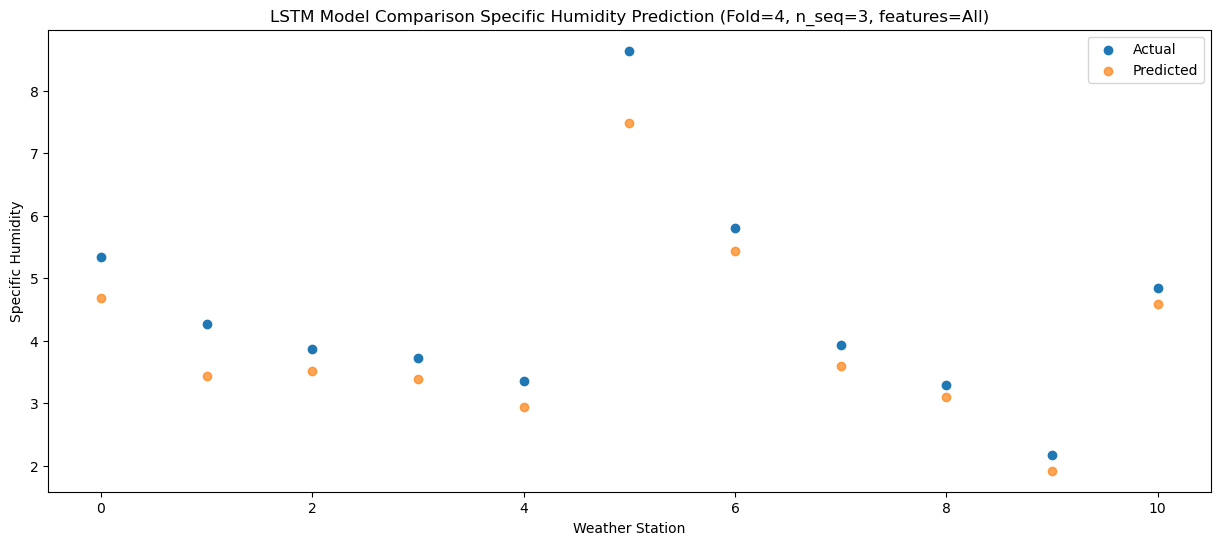

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    4.25   4.383533
1                 1    6.26   3.291926
2                 2    3.75   3.387778
3                 3    3.41   3.216838
4                 4    2.91   2.771404
5                 5    8.00   7.281508
6                 6    6.05   5.298083
7                 7    3.30   3.416140
8                 8    2.73   2.834939
9                 9    1.53   1.627050
10               10    4.27   4.245284


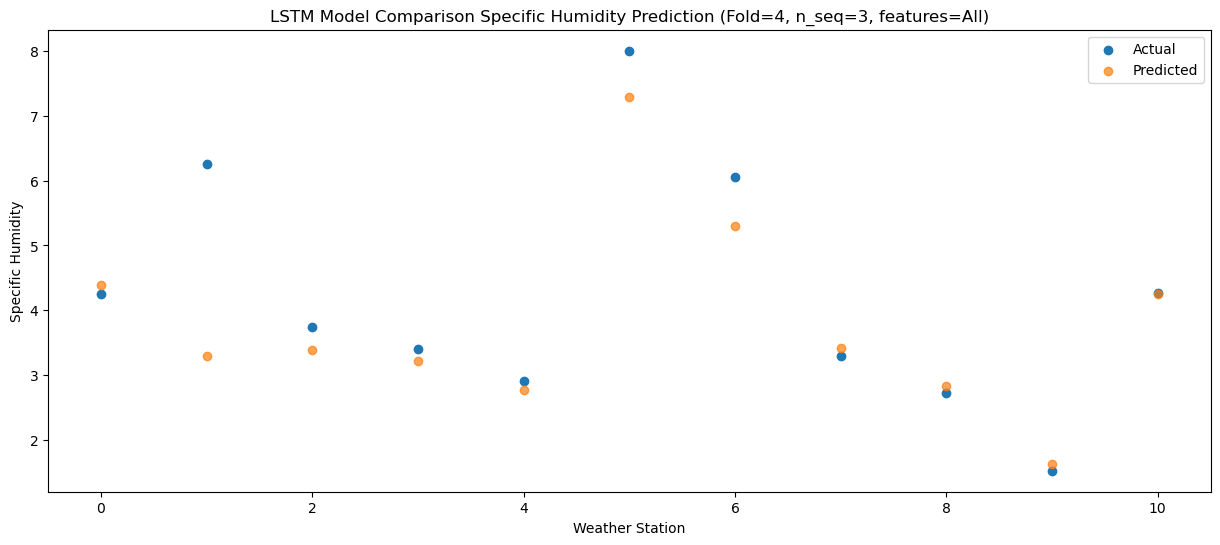

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    7.01   5.906102
1                 1    6.23   4.760150
2                 2    6.81   4.978224
3                 3    6.07   4.885103
4                 4    5.49   4.468887
5                 5    9.49   8.859787
6                 6    7.76   6.865919
7                 7    5.67   5.084561
8                 8    4.67   4.424393
9                 9    3.90   3.241096
10               10    5.56   5.700193


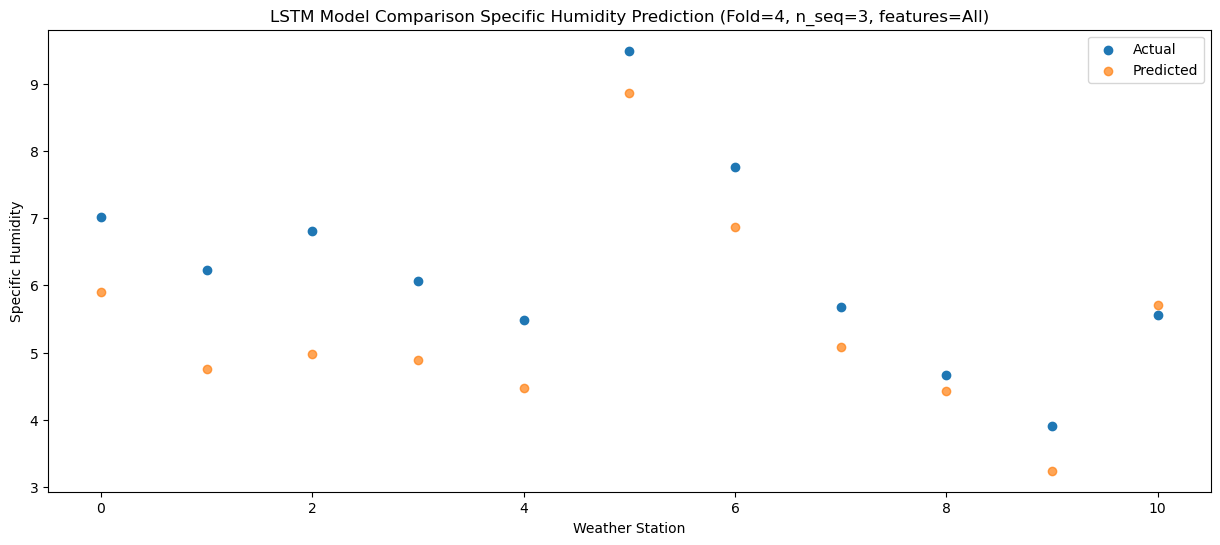

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (1, 1, 512)               5449728   
                                                                 
 dropout_18 (Dropout)        (1, 1, 512)               0         
                                                                 
 lstm_19 (LSTM)              (1, 512)                  2099200   
                                                                 
 dropout_19 (Dropout)        (1, 512)                  0         
                                                                 
 dense_27 (Dense)            (1, 256)                  131328    
                                                                 
 dense_28 (Dense)            (1, 128)                  32896     
                                                                 
 dense_29 (Dense)            (1, 3)                   

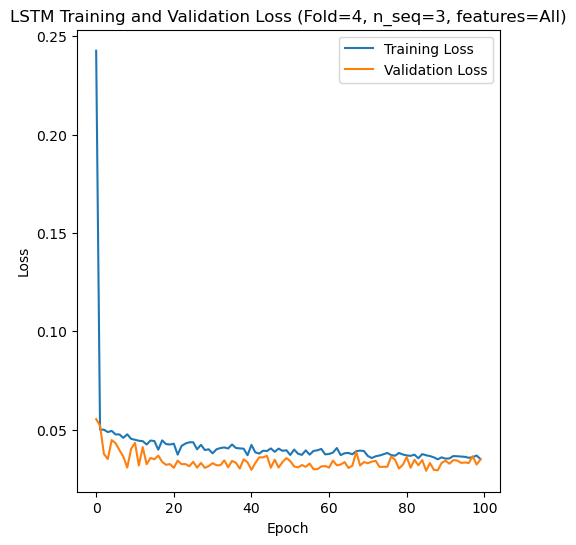

[[0.28092371281287404, 0.5673349974303209, 0.7712711846678613], [0.49263599044782636, 0.71343681244996, 1.2297520931551558], [0.47376072950879444, 1.2008380758482724, 1.247301352892312], [0.5514123319242342, 0.7832930740190196, 0.5348250418899267], [0.546210261086063, 0.9596948809142419, 1.0106040182958074]]
[[0.2404388952052048, 0.4429465425895014, 0.6456526222689581], [0.3953402145342397, 0.5916825285824866, 1.097209334806963], [0.34004849796945386, 0.7961841132965954, 1.0857893516258754], [0.4106417953426187, 0.6166533600742166, 0.46225739917971853], [0.4684203859892758, 0.5098945753682741, 0.8878155885501342]]
[[0.044536267448519254, 0.09028155543103769, 0.09008228426318741], [0.08869725923301736, 0.14140959086204707, 0.1707411700690542], [0.0695312601502344, 0.142483746690782, 0.1627880969649058], [0.11571338875954687, 0.18262856769188074, 0.10507128490992663], [0.10296320059756615, 0.09666969359627965, 0.14320210255738425]]
[[0.9280568997877742, 0.8129407426222166, 0.454267508391

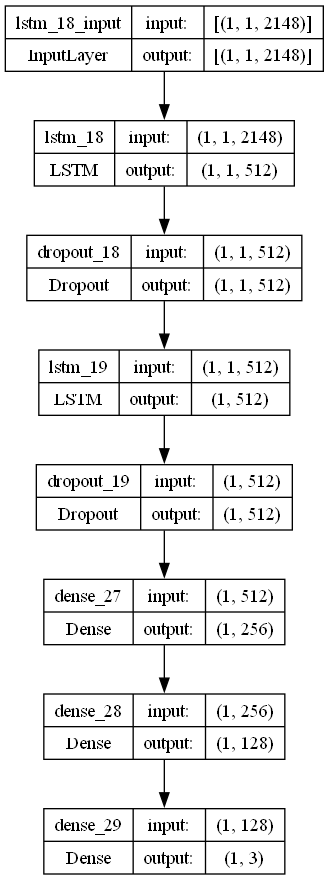

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from best model
    lr = 0.003896240896509942
    optimizer = SGD(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 512
    dropout_rate = 0.16023351213312673

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with an LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # Create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S3.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)